Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree5M_ml_DCM_12gev.root'
# fileName = directory + 'PlainTree10K_ml_DCM_12gev.root'
fileNameTest = directory + 'PlainTree1M_ml_URQMD_12gev.root'
# fileNameTest = directory + 'PlainTree10k_ml_DCM_12gev.root'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from bayes_opt import BayesianOptimization
# from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [3]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
m2LowerCut = -1
m2UpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    # ELECTRON = 11
    # POSITRON = -11
    ELECTRON = 11
    PROTON = 2212 
    # NEG_MUON = -13
    # POS_MUON = 13
    MUON = 13
    # NEG_PION = -211
    # POS_PION = 211 
    PION = 211
    # NEG_KAON = -321
    # POS_KAON = 321 
    KAON = 321
    BCKGR = 999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    # #t
    # size_t =  len(df['t'])
    # is_good_t = (df['t'] < tUpperCut)
    # percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    #mass2
    size_m2 =  len(df['mass2'])
    is_good_m2 = (df['mass2'] > m2LowerCut) & (df['mass2'] < m2UpperCut)
    percentage_m2 = ( size_m2 - len(df[is_good_m2]) ) / size_m2
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_m2) #& (is_good_t)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['pid']==pid]['mass2'].mean()
    std = df[df['pid']==pid]['mass2'].std()
    out_sigma = (df['pid']==pid) & ((df['mass2'] < (mean-nsigma*std)) | (df['mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1

def xgb_preds(df, probaProton, probaKaon, probaPion):
    #getting max field
    df['xgb_preds']=df[[0, 1, 2]].idxmax(axis = 1)
    #setting to bckgr if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df[0] < probaProton )
    pion   = (df['xgb_preds'] == 1) & (df[1] < probaKaon )
    kaon   = (df['xgb_preds'] == 2) & (df[2] < probaPion )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 3
    return df

from collections import defaultdict
def remap_names(dataframe):
    return dataframe.pid.abs().map(defaultdict(lambda: 3, {Pid.PROTON.value : 0, Pid.KAON.value : 1, Pid.PION.value : 2, Pid.ELECTRON.value : 2, Pid.MUON.value : 2}),na_action='ignore')
 

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [4]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [5]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()
particles.iloc[0:10,:]

,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,1.928141,0.139570,-0.011916,1.572914,0.447987,-0.610026,0.367185,-0.256647,1.507769,1.883827,-211.0,-1.0
1,2.500318,0.139570,-0.009863,5.464226,0.890780,-1.681210,-0.098154,-0.885356,5.391130,2.488354,211.0,1.0
2,1.806927,0.139570,0.008711,2.865169,0.915995,-2.710099,-0.832037,-0.383095,2.714801,1.796060,-211.0,-1.0
3,2.115173,0.139570,0.017425,1.882905,0.447691,-2.514619,-0.362543,-0.262659,1.828908,2.070187,211.0,1.0
4,2.097679,0.938272,-0.237758,1.499275,0.362582,-2.560894,-0.303147,-0.198916,1.454771,1.164573,2212.0,-1.0
5,2.398703,0.493677,0.278050,1.294498,0.233248,-2.376918,-0.168314,-0.161478,1.273311,1.582983,321.0,1.0
6,2.667830,0.938272,0.796354,13.857271,1.914243,-2.004751,-0.804867,-1.736811,13.724418,2.561323,2212.0,1.0
7,2.572647,0.938272,0.868623,1.646631,0.249930,-1.007132,0.133534,-0.211266,1.627553,1.288680,2212.0,1.0
8,2.134996,0.139570,-0.041930,3.193019,0.744705,-0.563221,0.629678,-0.397607,3.104961,2.118219,-211.0,1.0
9,2.228435,0.493677,0.204404,1.916363,0.408040,-2.585814,-0.346626,-0.215284,1.872419,1.793962,321.0,1.0


In [6]:

particles['pid'] = remap_names(particles)
#dropping bckgr value for training
particles = particles[particles['pid'] != 3]
gc.collect()
print('number of particles before downsampling : ' + str(len(particles)))

#downsampling the data

particles = downsample(particles, 'pid')
print('number of particles per class after downsampling : ' + str(len(particles)/3))
particles.iloc[0:10,:]


number of particles before downsampling : 186051845
number of particles per class after downsampling : 5120260.0


,eta,mass,mass2,p,pT,phi,px,py,pz,rapidity,pid,q
0,3.371492,0.938272,0.888208,4.348176,0.298265,-0.996541,0.162020,-0.250422,4.337934,2.188764,0,1.0
1,1.684462,0.938272,0.740175,2.261207,0.811182,1.893622,-0.257345,0.769278,2.110697,1.301707,0,-1.0
2,2.000372,0.938272,0.958860,0.762618,0.202633,0.612075,0.165846,0.116426,0.735205,0.705831,0,1.0
3,2.274609,0.938272,0.838173,2.365174,0.481364,1.135261,0.203085,0.436426,2.315672,1.527961,0,1.0
4,2.261776,0.938272,0.846584,1.468224,0.302593,-1.229330,0.101329,-0.285123,1.436704,1.170849,0,-1.0
5,1.803768,0.938272,0.872378,1.798456,0.576690,1.569970,0.000476,0.576690,1.703488,1.220422,0,1.0
6,1.561640,0.938272,0.127798,0.893417,0.359060,1.422753,0.052963,0.355133,0.818090,0.743812,0,1.0
7,1.699860,0.938272,0.841679,0.906230,0.320455,1.426849,0.045970,0.317141,0.847680,0.775011,0,1.0
8,2.573972,0.938272,0.816479,3.281405,0.497406,2.576700,-0.420132,0.266274,3.243487,1.835459,0,1.0
9,1.974211,0.938272,0.881087,2.118661,0.577307,0.339497,0.544356,0.192250,2.038490,1.374655,0,-1.0


we get rid of 5.05 % of pid = 0 particle entries
we get rid of 4.9 % of pid = 1 particle entries
we get rid of 2.17 % of pid = 2 particle entries


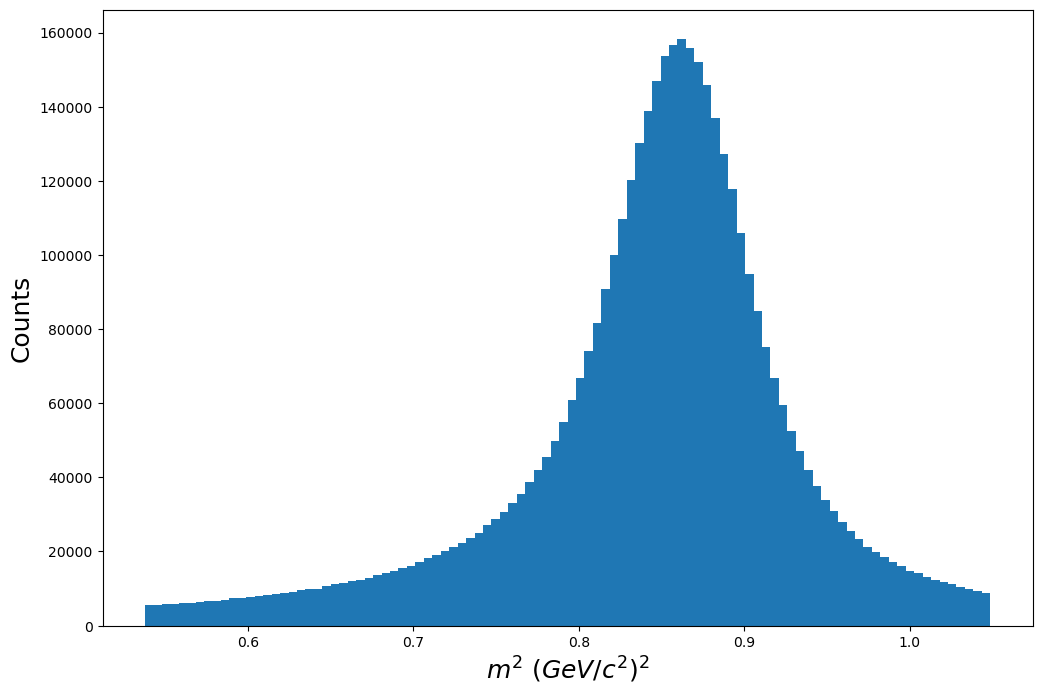

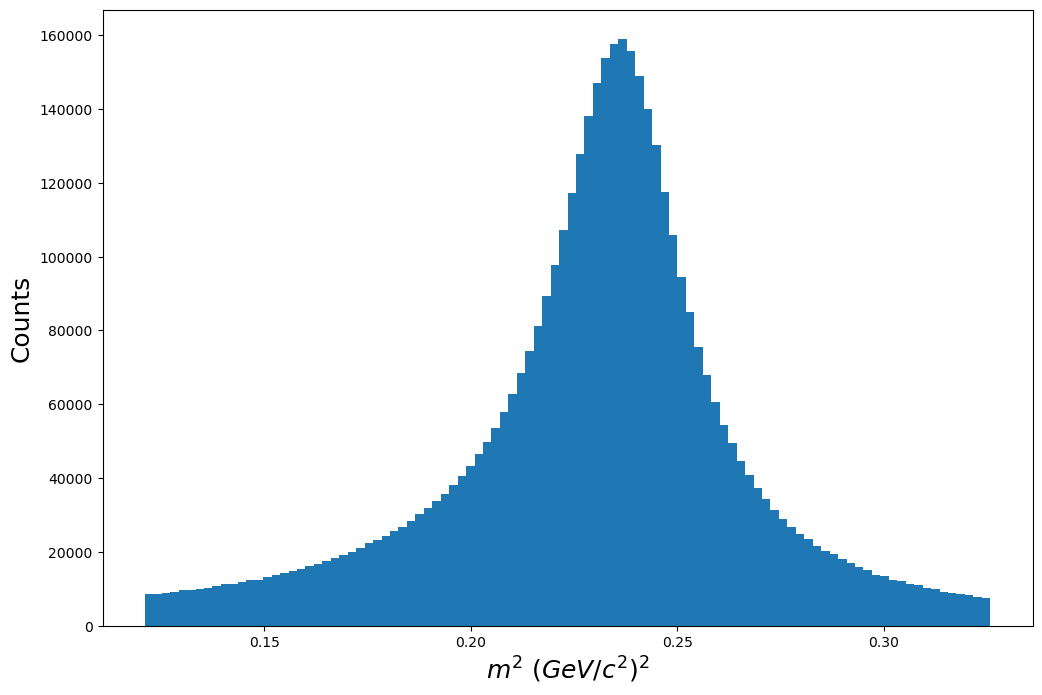

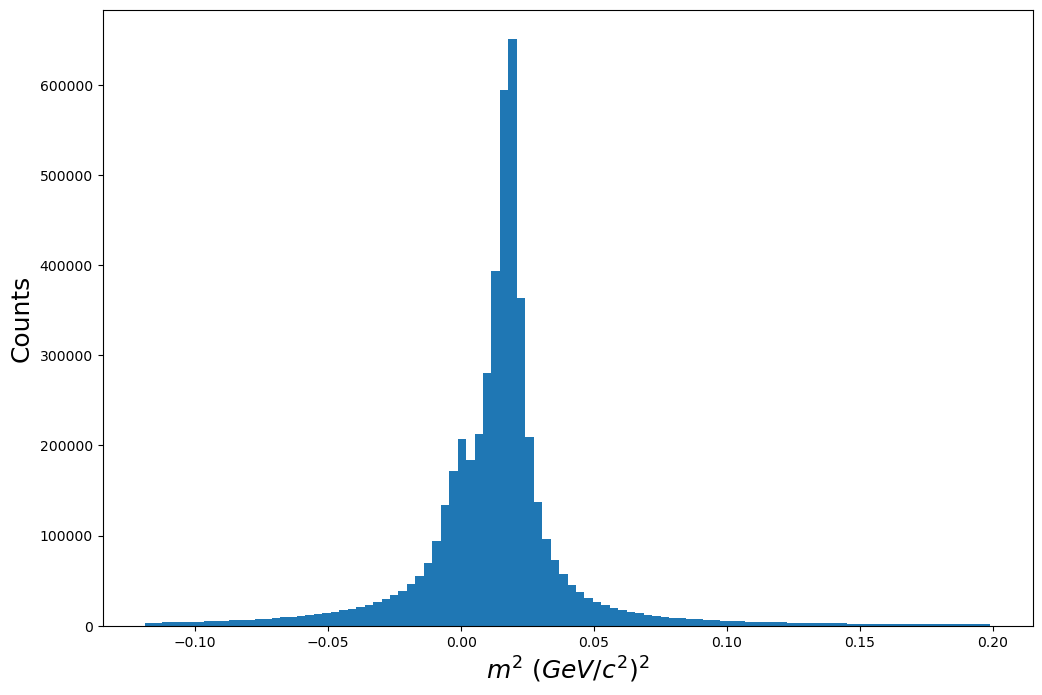

In [7]:
#cleaning and 1sigma region selection
particles = clean_df(particles)
for particle in particles['pid'].unique(): 
    particles = sigma(particles, particle, 1, True)
#we check sigma selection
for pid in particles['pid'].unique():
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.hist(particles[particles['pid'] == pid]['mass2'], bins=100)
    ax.set_xlabel(r'$m^2$ $(GeV/c^2)^2$',fontsize=18)
    plt.ylabel('Counts', fontsize=18)
    # ax.set_yscale('log')
    
    plt.show()

In [8]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
params = ['mass2', 'p', 'pT', 'eta']
x = particles[params].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(particles['pid'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=324)
del particles, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
# dtest1=xgb.DMatrix(x_test, label = y_test)
# del x_test
gc.collect()

18233

In [ ]:
def bo_tune_xgb(max_depth, gamma, alpha, eta, subsample):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'eta':eta,
              'subsample': subsample,
              # 'eta': 0.3, - it is now same as the learning rate
              'num_class':np.unique(dtrain.get_label()).shape[0],
              'objective':'multi:softprob', 
              'eval_metric': 'mlogloss',
              # 'tree_method':'hist', 'nthread' : 7
             }
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return (1 -  cv_result['test-mlogloss-mean'].iloc[-1])
    
# bounds_transformer = SequentialDomainReductionTransformer()
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 14),
                                             'alpha': (0,10),
                                             'gamma': (0, 4),
                                             'subsample': (0.6, 0.9),
                                             'eta':(0.1, 0.8), #learning rate
                                            })



In [12]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   |    eta    |   gamma   | max_depth | subsample |
-------------------------------------------------------------------------------------
|  2        |  0.986    |  6.588    |  0.6539   |  2.072    |  9.47     |  0.6845   |
|  3        |  0.983    |  5.5      |  0.523    |  1.507    |  10.05    |  0.633    |
|  4        |  0.9689   |  9.966    |  0.3751   |  0.6319   |  9.118    |  0.7236   |
|  5        |  0.9863   |  0.8387   |  0.6901   |  0.2298   |  4.998    |  0.8566   |


KeyboardInterrupt: 

In [13]:
print(xgb_bo.max['params'])

{'alpha': 2.968264252908895, 'eta': 0.7723775650438347, 'gamma': 3.151398198467347, 'max_depth': 9.62397355879584, 'subsample': 0.6464842015787604}


In [9]:
# max_param = xgb_bo.max['params']
max_param = {'alpha': 2.968264252908895, 'eta': 0.7723775650438347, 'gamma': 3.151398198467347, 
        'max_depth': 9.62397355879584, 'subsample': 0.6464842015787604}
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'eta': max_param['eta'],
        'max_depth': int(round(max_param['max_depth'],0)), 'num_class':np.unique(dtrain.get_label()).shape[0],
        'objective':'multi:softprob','eval_metric': 'mlogloss', 'subsample': max_param['subsample'], 
        'tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param, use_label_encoder=False).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
bst_train['pid']=y_train['pid']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
bst_test['xgb_preds']=bst_test.iloc[:,0:(len(bst_test.columns)-1)].idxmax(axis = 1)
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['pid']=y_test['pid']
del x_train, x_test, y_train, y_test, dtrain
gc.collect()

0

## Another set
We also select the selected variables from the 10k events data set

In [10]:
# We import three root files into our jupyter notebook
particlesTest = tree_importer.tree_importer(fileNameTest,'plain_tree',7)
particlesTest.columns = particlesTest.columns.str.replace('Complex_', '')
particlesTest = clean_df(particlesTest)
gc.collect()
#changign to the same pid as in training
particlesTest['pid'] = remap_names(particlesTest)
particlesTest.iloc[0:10,:]

,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,2.795109,796.765564,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,26.631847,2,-1.0
1,2.862100,797.093079,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,26.975466,1,1.0
2,2.025051,785.335205,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,27.855837,0,1.0
3,1.962085,745.262451,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,25.919329,0,1.0
4,2.162448,734.718689,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,24.501303,2,-1.0
5,3.121445,792.576599,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,26.742485,0,1.0
6,2.217318,759.005249,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,27.027834,0,1.0
7,2.333610,749.677795,0.139570,0.015155,3.696914,0.710121,2.618707,-0.615236,0.354622,3.628071,2.315019,25.072449,2,1.0
8,2.156020,733.076660,0.139570,0.015053,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,2.150286,24.501919,2,1.0
9,2.211525,769.359009,0.139570,0.018099,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,25.997503,2,1.0


In [11]:
x_whole = particlesTest[params].copy()
y_whole = pd.DataFrame(particlesTest['pid'], dtype='int')

whole_test= pd.DataFrame(data=bst.predict_proba(x_whole))
y_whole=y_whole.set_index(np.arange(0,whole_test.shape[0]))

whole_test['pid']=y_whole['pid']
gc.collect()

9

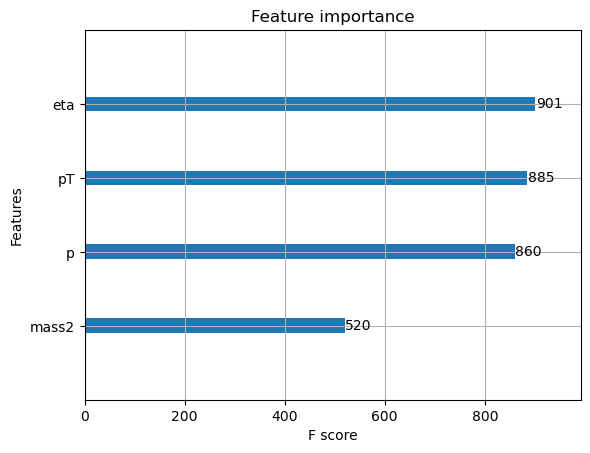

In [12]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.pdf')
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.png')

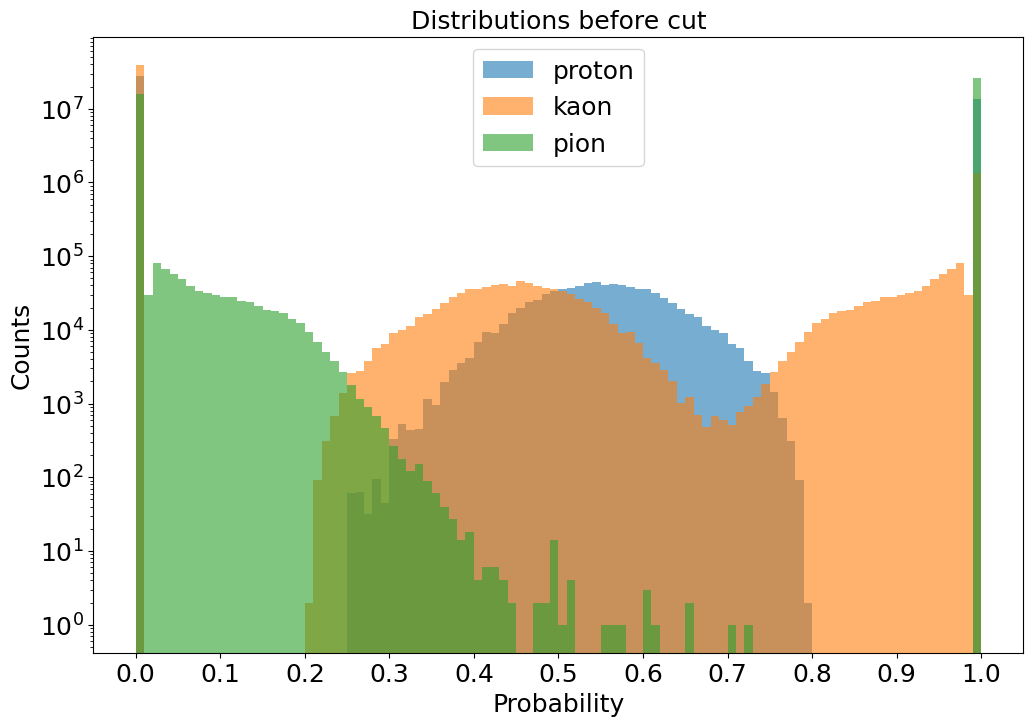

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # kaon 
plt.hist(whole_test[1], bins = 100, label='kaon', alpha = .6) # kaon 
plt.hist(whole_test[2], bins = 100, label='pion', alpha = .6) # kaon 
# plt.hist(whole_test[whole_test['pid']==1][1], bins = 100, label='kaon', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[2], bins = 100, label='pion', alpha = .6) # pion 

ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.title('Distributions before cut', fontsize=18)
plt.legend(fontsize=18)
plt.show()

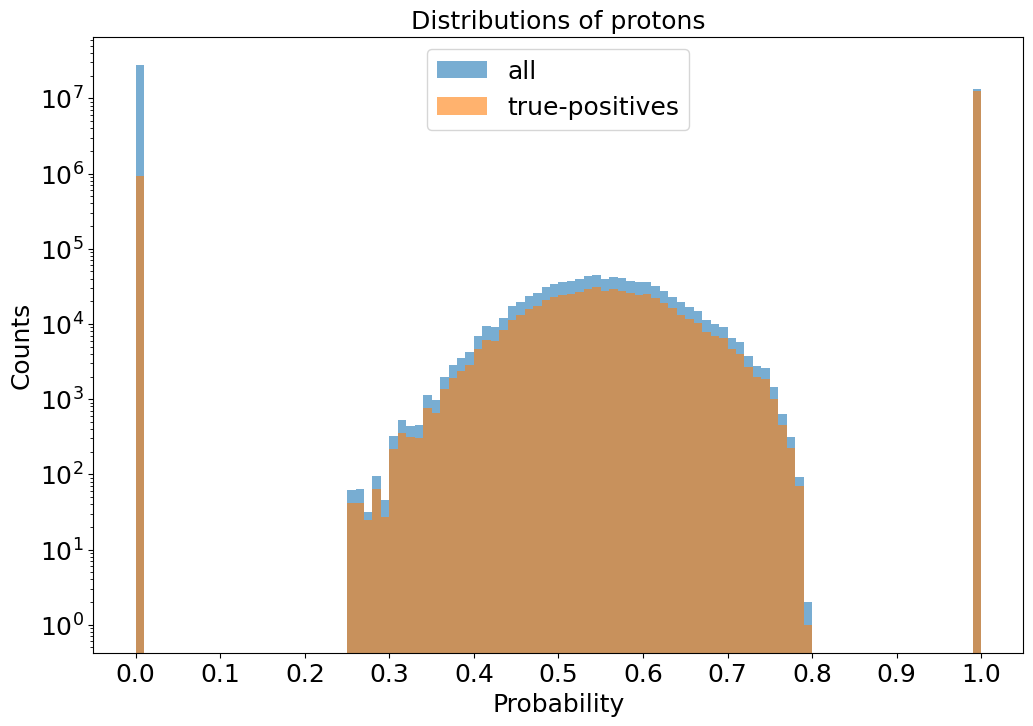

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[0], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of protons', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

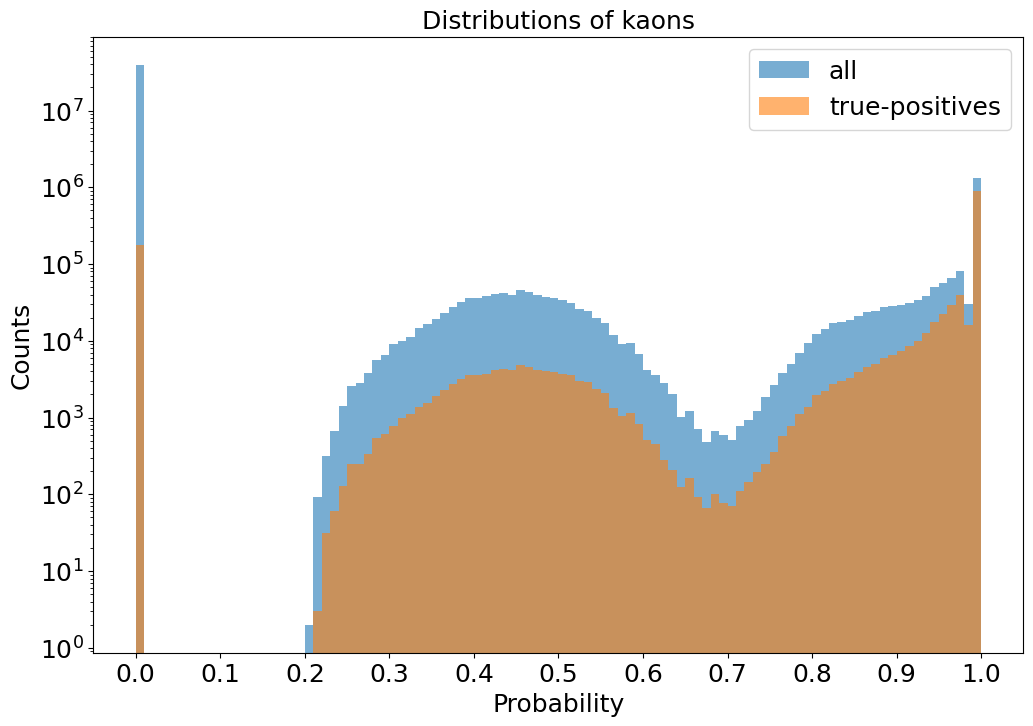

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[1], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==1][1], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of kaons', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

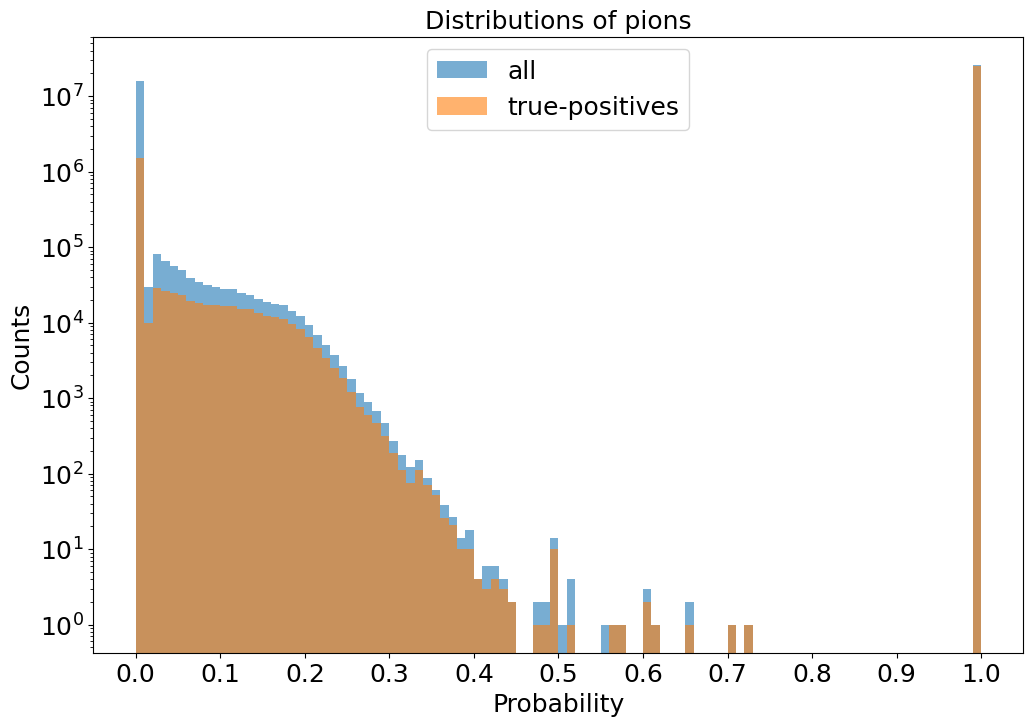

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
# plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
# plt.hist(whole_test[whole_test['pid']==0][0], bins = 100, label='proton', alpha = .6) # proton

plt.hist(whole_test[2], bins = 100, label='all', alpha = .6) # kaon 
plt.hist(whole_test[whole_test['pid']==2][2], bins = 100, label='true-positives', alpha = .6) # kaon 

plt.title('Distributions of pions', fontsize=18)
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_yscale('log')
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

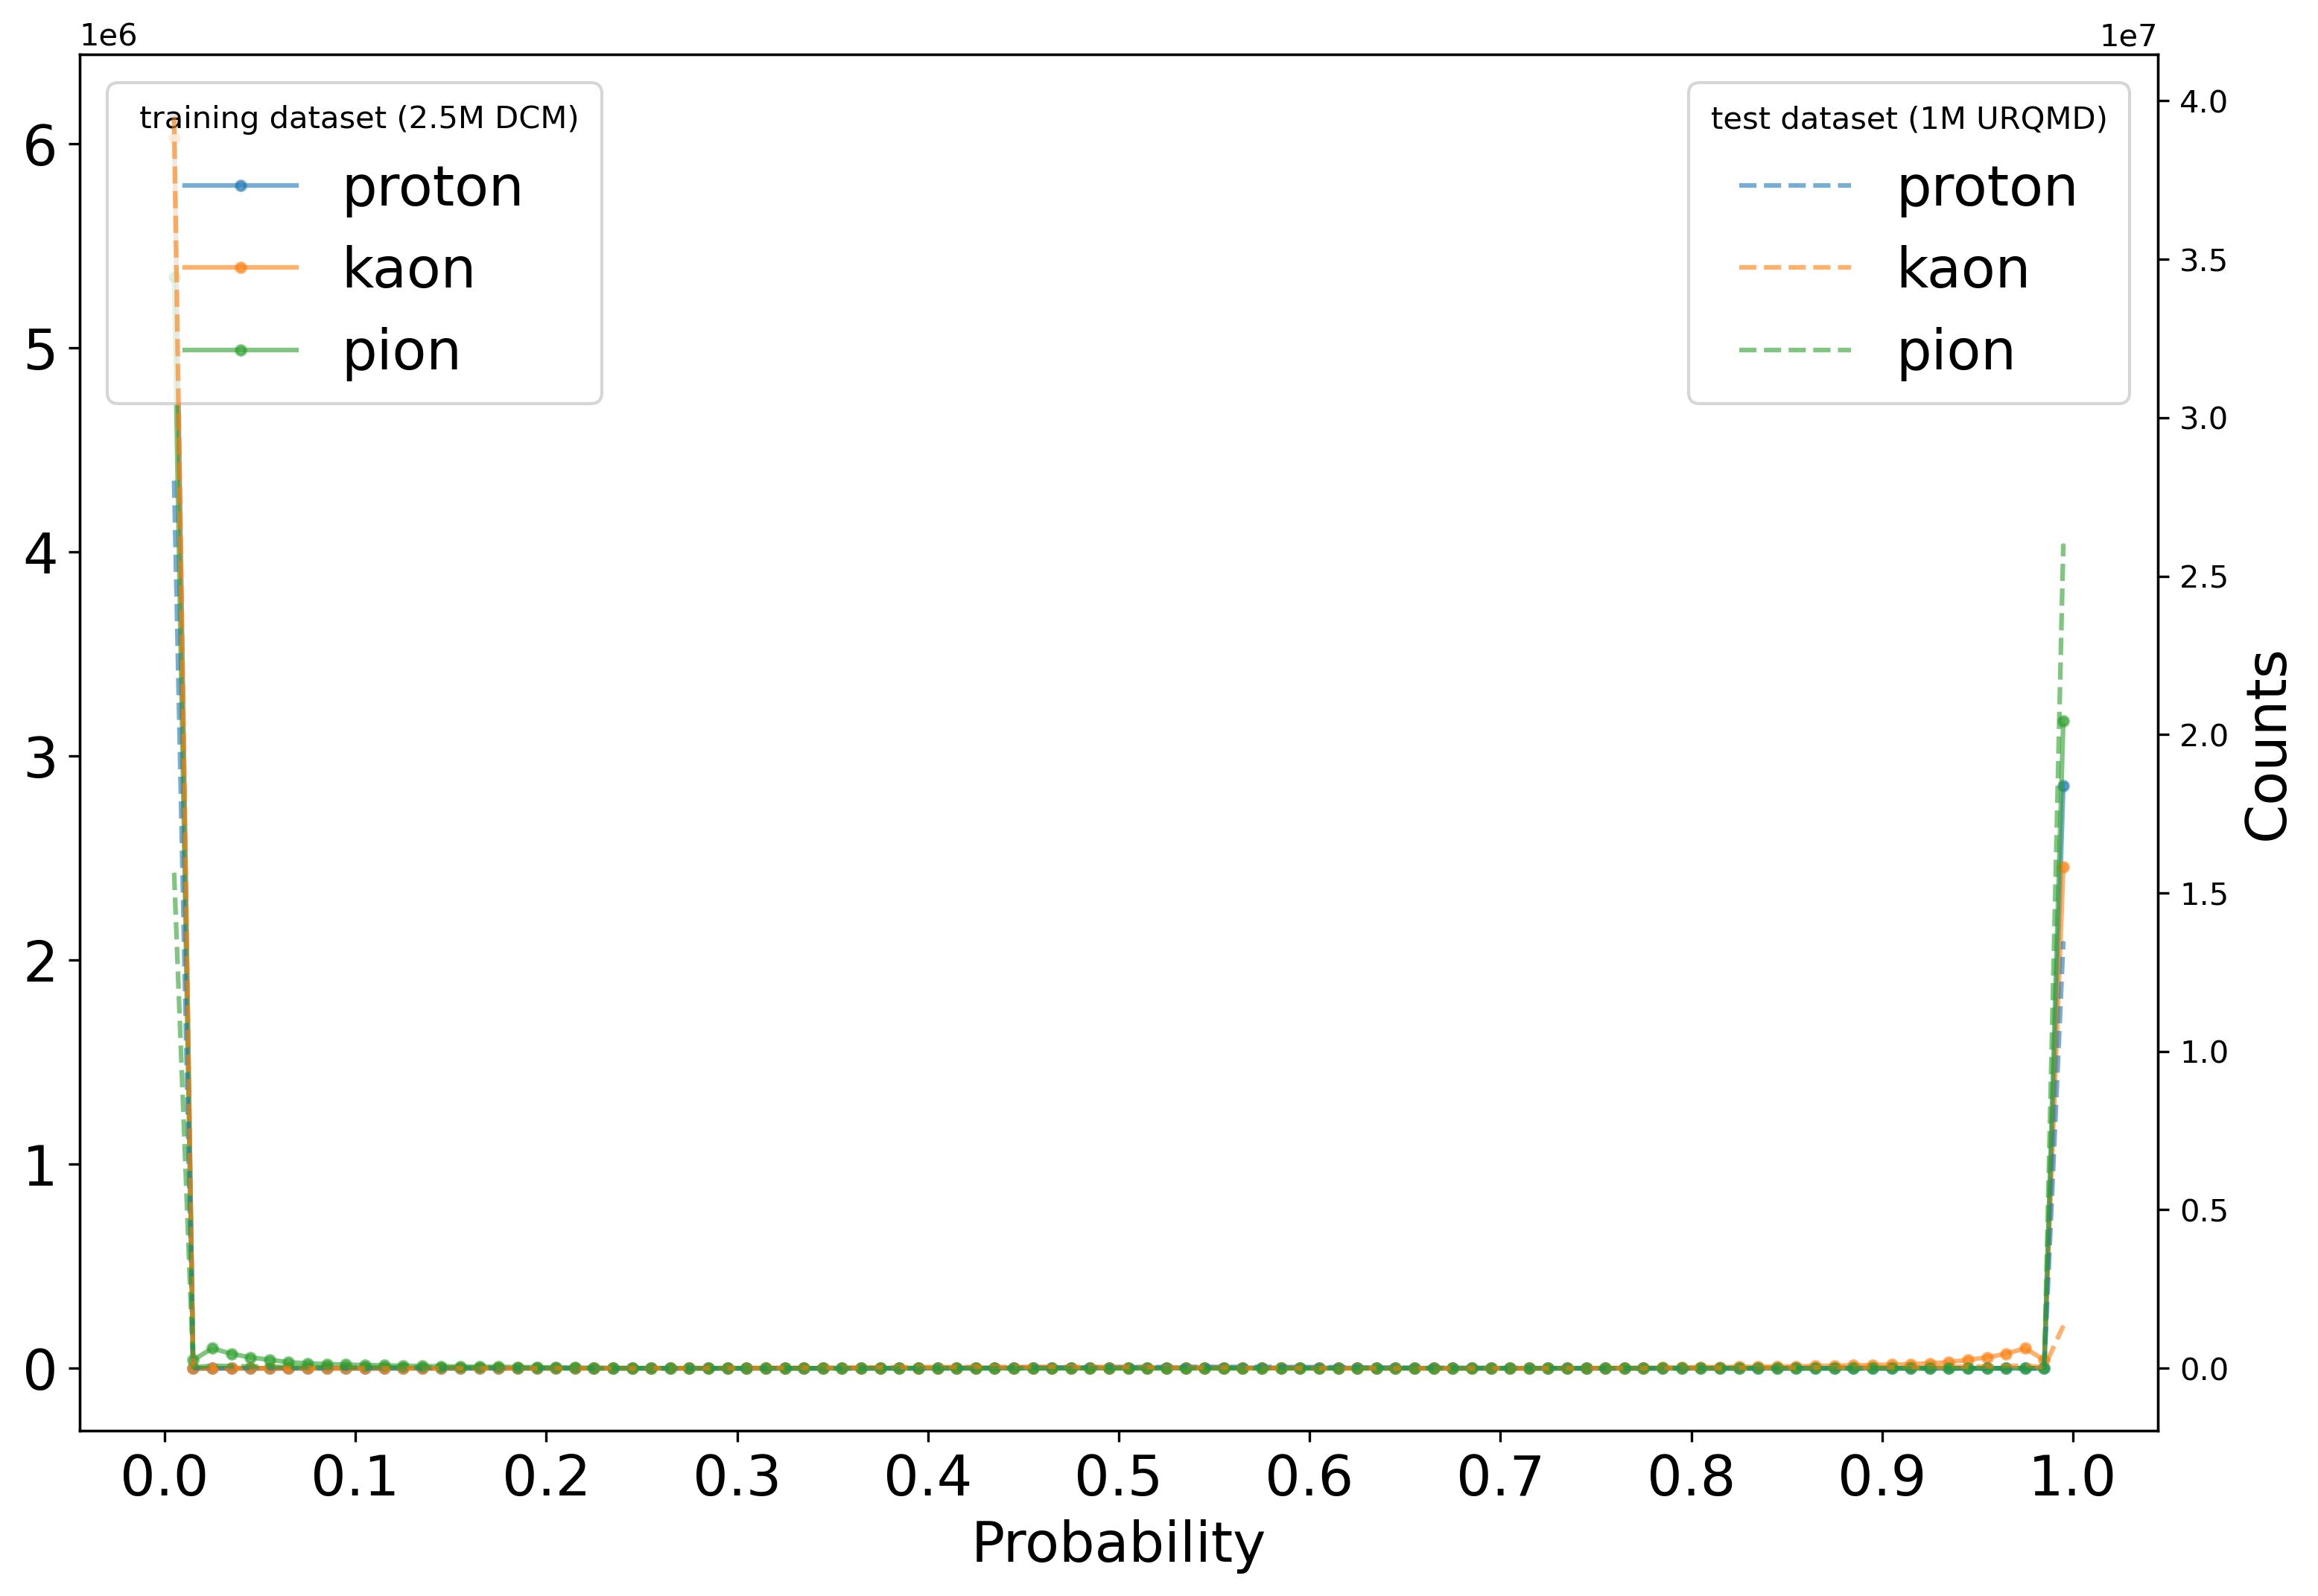

In [17]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

ax2 = ax.twinx()

def subplot(df1, df2, i, label):
    counts, bin_edges = np.histogram(df1[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax.plot(bin_centers, counts, label=label, alpha = .6, marker='.')
    # ax.hist(df1[i], bins = 100, alpha = .6) 
    
    counts, bin_edges = np.histogram(df2[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, label=label, alpha = .6, marker=',', linestyle='dashed')
    # ax.hist(df2[i], bins = 100, alpha = .6) 
    
subplot(bst_train, whole_test, 0, 'proton') 
# subplot(bst_train, whole_test, 1, 'pion')
subplot(bst_train, whole_test, 1, 'kaon')
subplot(bst_train, whole_test, 2, 'pion')
# subplot(bst_train, whole_test, 3, 'bckgr')
ax.legend(title= ' training dataset (2.5M DCM)', fontsize = 18, loc='upper left')
ax2.legend(title= 'test dataset (1M URQMD)',fontsize = 18,loc='upper right' )
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

# ax.text(0.51, 220000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$; 2.5M events', fontsize=16, color = 'black')
# ax2.text(0.52, 35000, r'URQMD, Au+Au @12 $A$GeV/$c$; 1M events', fontsize=16, color = 'black')
plt.show()

before cuts

In [18]:
#set probability cut
probaProton, probaKaon, probaPion,  = 0.0, 0.0, 0.00
whole_test = xgb_preds(whole_test, probaProton, probaKaon, probaPion)
particlesTest.index = whole_test.index
particlesTest['xgb_preds'] = whole_test['xgb_preds']

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[12804372   416959   642620        0]
 [   79989  1132431   161494        0]
 [ 1198521   647541 25204023        0]
 [    7675     1527    11190        0]]


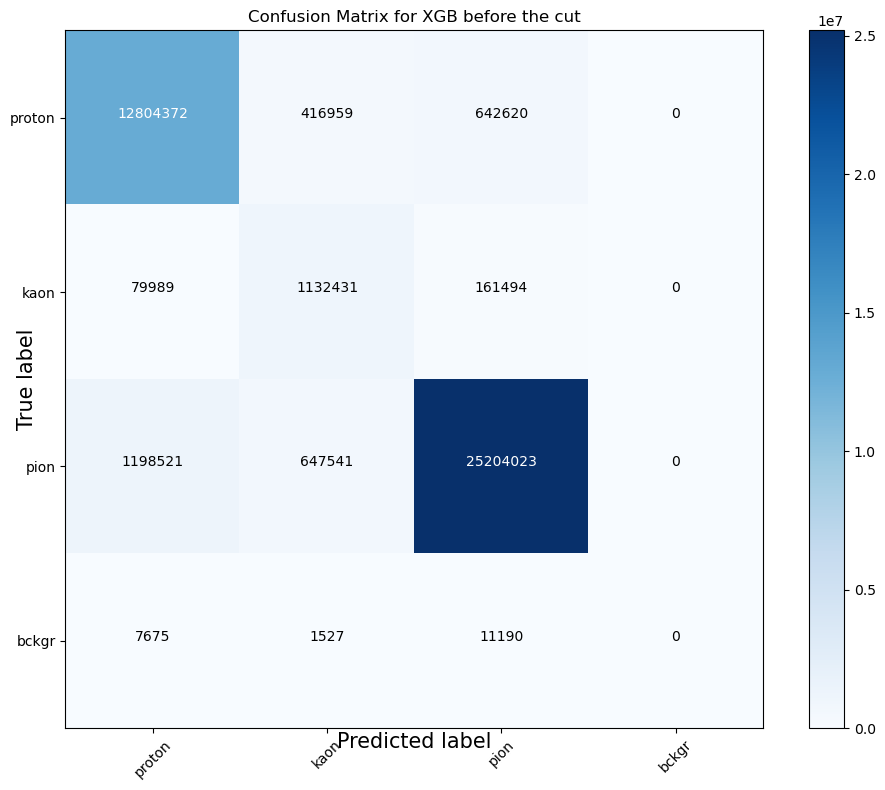

In [20]:
classes = ['proton', 'kaon', 'pion', 'bckgr']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
# fig.savefig(directory+'img/' + title + '.pdf')
plt.show()

Normalized confusion matrix
[[0.92 0.03 0.05 0.  ]
 [0.06 0.82 0.12 0.  ]
 [0.04 0.02 0.93 0.  ]
 [0.38 0.07 0.55 0.  ]]


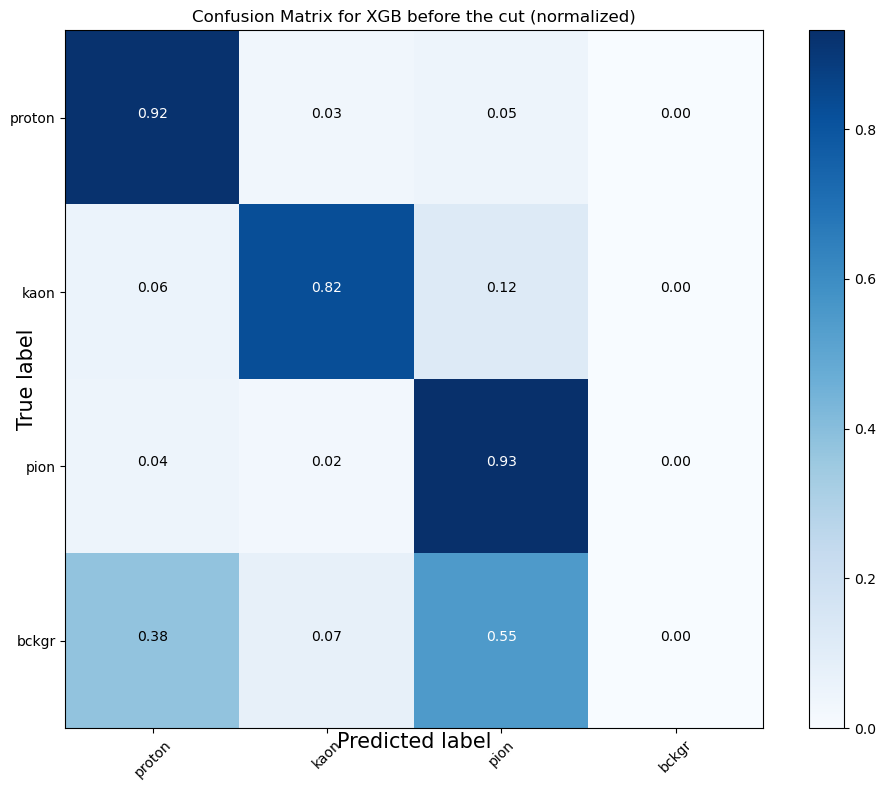

In [21]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB before the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
# fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

In [22]:
def plot_mass2(pid, name, range1, setLog=False):

    # fig, axs = plt.subplots(2, 1,figsize=(15,10), sharex=True,  gridspec_kw={'width_ratios': [10],
    #                            'height_ratios': [8,4]})
    fig, axs = plt.subplots(figsize=(15,10))

    
    xgb_mass = particlesTest[particlesTest['xgb_preds']==pid]['mass2']
    sim_mass = particlesTest[particlesTest['pid']==pid]['mass2']
    
    ns, bins, patches=axs.hist(xgb_mass ,bins = 300,  facecolor='red',alpha = 0.3, range=range1)
    ns1, bins1, patches1=axs.hist( sim_mass ,bins = 300,facecolor='blue',alpha = 0.3, range=range1)
    #plt.xlabel("Mass in GeV", fontsize = 15)
    axs.set_ylabel("counts", fontsize = 15)
    #axs[0].grid()
    axs.legend(('XGBoost selected ' + name,'all simulated ' + name), fontsize = 15, loc='upper right')

    #plt.rcParams["legend.loc"] = 'upper right'
    title = "The " + name +  " Invariant Mass histogram with KFPF and XGB selection criteria on KFPF variables"
    axs.set_title(title, fontsize = 15)
    axs.grid()
    axs.tick_params(axis='both', which='major', labelsize=15)
    #fig.savefig("whole_sample_invmass_with_ML.png")


    # hist1, bin_edges1 = np.histogram(xgb_mass, bins=200, range=range1)
#     hist2, bin_edges2 = np.histogram(sim_mass, bins=200, range=range1)

#     #ratio checked with division by 0
#     ratioBlue = [] #ratio smaller than 1
#     ratioRed = [] # ratio bigger than 1
#     for i in range(len(ns1)):
#         if (ns1[i] != 0):
#             ratio = ns[i] / ns1[i]
#             if (ratio < 1):
#                 ratioBlue.append(ratio)
#                 ratioRed.append(0)
#             else:
#                 ratioBlue.append(0)
#                 ratioRed.append(ratio)
#         else:
#             ratioBlue.append(0)
#             ratioRed.append(0)
#     #col = []
#     # for val in ratio:
#     #     if val < 1:
#     #         col.append('blue')
#     #     else:
#     #         col.append('red')        
#     axs[1].bar(bins[:-1],     
#             ratioBlue, 
#             width=0.001,
#             color = 'blue',
#             label='ratio < 1')
#     axs[1].bar(bins[:-1],     
#             ratioRed, 
#             width=0.001,
#             color = 'red',
#             label='ratio >= 1')
#     axs[1].legend( loc='upper right')
#     plt.xlabel("Mass in $\dfrac{GeV}{c^2}$", fontsize = 15)
#     axs[1].set_ylabel("XGB / KFPF", fontsize = 15)
#     axs[1].grid()
#     #axs[1].set_ylim([0.,2.5])
#     axs[1].tick_params(axis='both', which='major', labelsize=15)
    if setLog:
        axs.set_yscale('log')

    plt.show()
    fig.tight_layout()
    # fig.savefig(directory+'img/' + title + '.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.png')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/kaon_inv_mass_comparison.pdf')

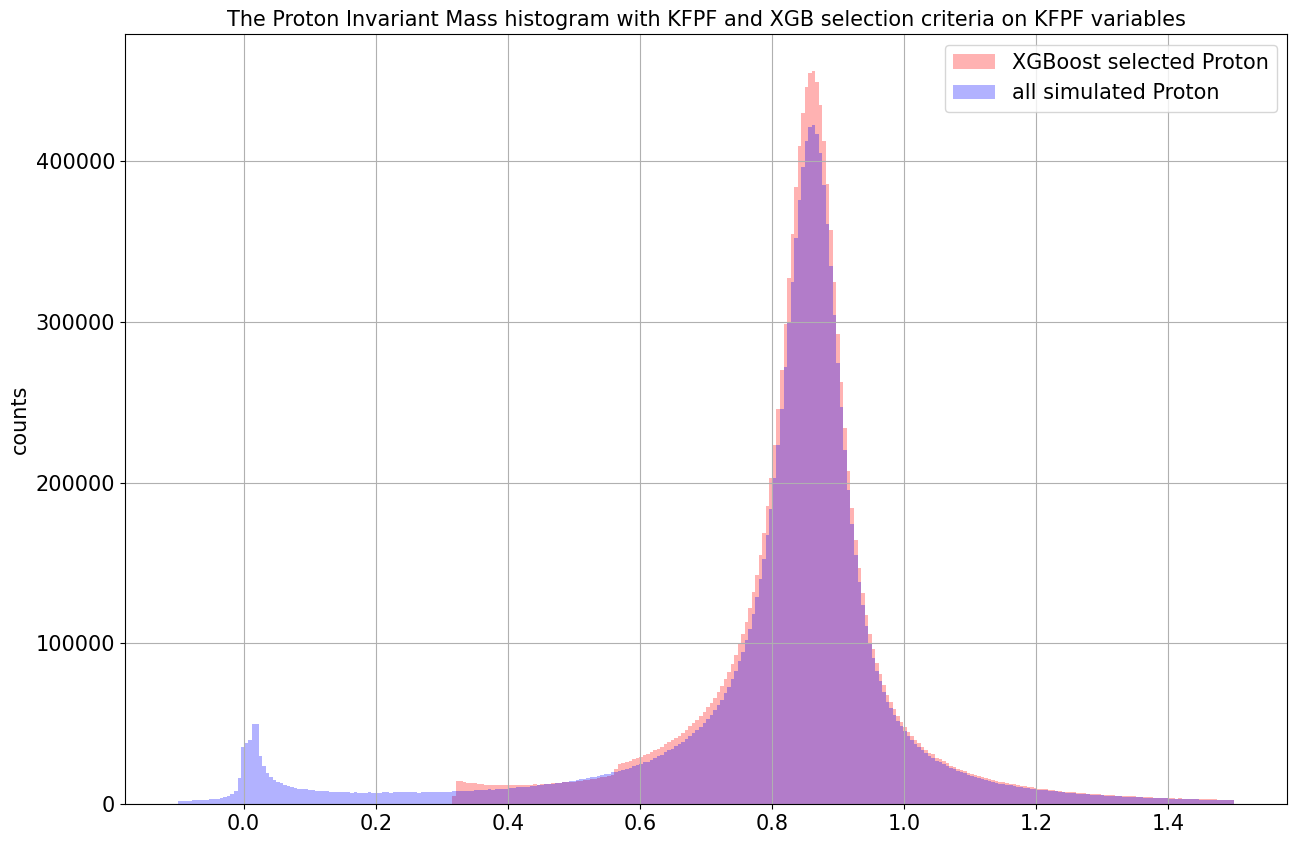

In [23]:
plot_mass2(0, 'Proton', (-.1, 1.5))

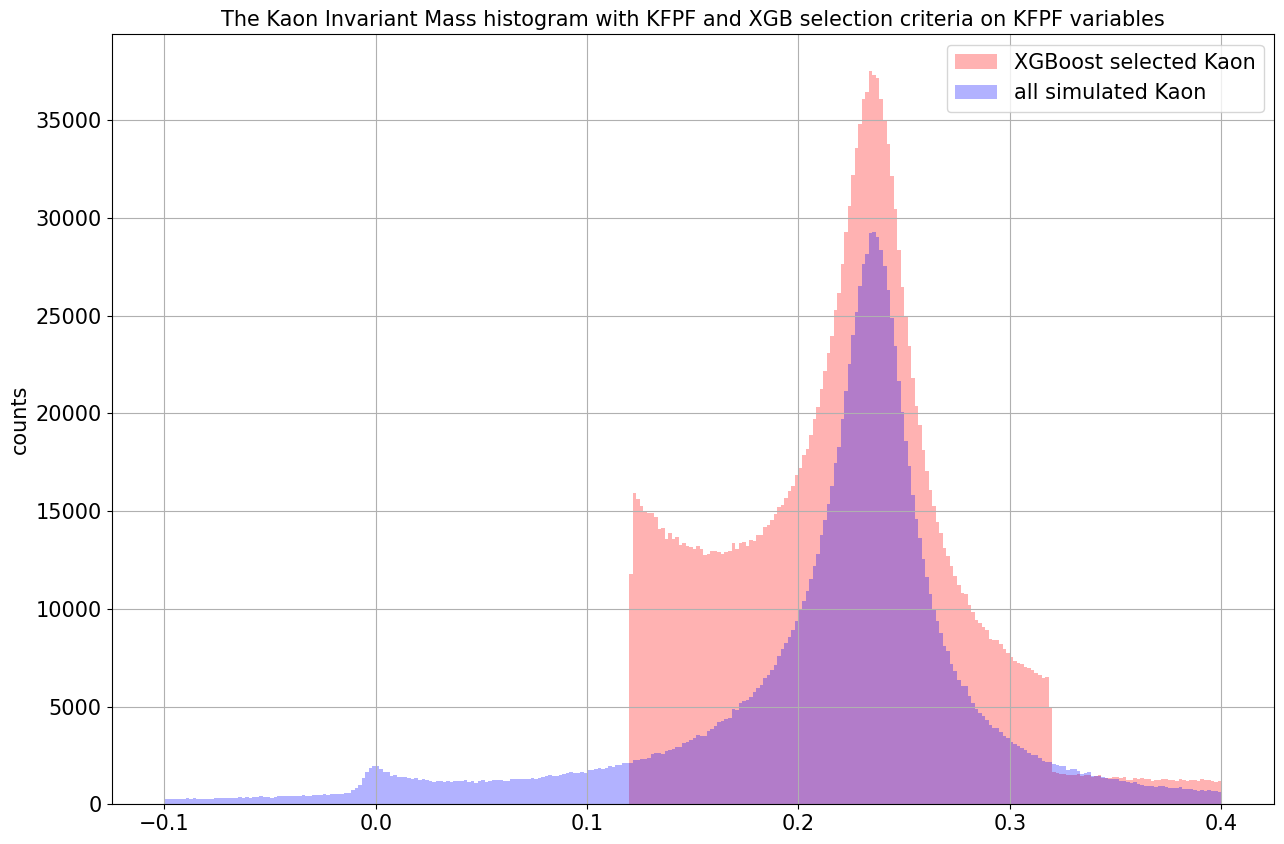

In [24]:
plot_mass2(1, 'Kaon', (-.1, .4))

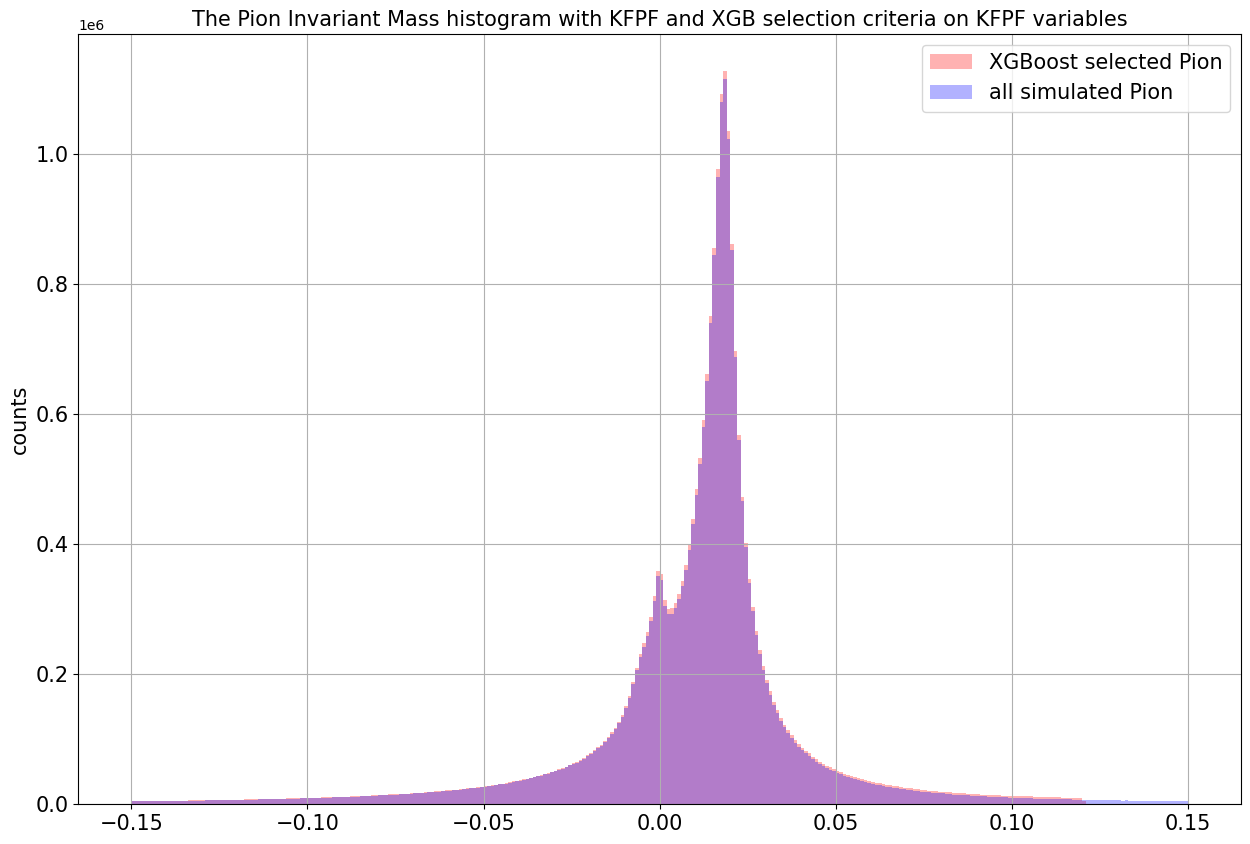

In [25]:
plot_mass2(2, 'Pion', (-.15, .15))

In [26]:
import matplotlib as mpl
def xgb_tof(pid):

    qp = particlesTest[particlesTest['xgb_preds']==pid]['q']*particlesTest[particlesTest['xgb_preds']==pid]['p']
    var_xaxis = qp
    mass2 = particlesTest[particlesTest['xgb_preds']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for XGB-selected particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

In [27]:
import matplotlib as mpl
def sim_tof(pid):

    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    var_xaxis = qp
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    var_yaxis = mass2
    #get name with variable from the xnames list
    xName = r'sign($q$) $\cdot p$ (GeV/c)'
    yName = r'$m^2$ $(GeV/c)^2$'
    ranges = [[-10, 10],[-1, 2]]
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=200, norm=mpl.colors.LogNorm(), range=ranges)
    # plt.hist2d(var_xaxis,var_yaxis)

    # hBefore, xedges, yedges = np.histogram2d(var_xaxis, var_yaxis, bins=80) #for efficiency graph

    plt.xlabel(xName, fontsize=20, loc='right')
    plt.ylabel(yName, fontsize=20, loc='top')
    title='TOF 2D plot for all simulated particle ID = ' + str(pid)
    plt.title(title, fontsize=20)
    #axs.tick_params(labelsize=18)
    fig.tight_layout()
    plt.colorbar() #shows legend
    plt.show()
    # fig.savefig(directory+'img/' + title + '.pdf')

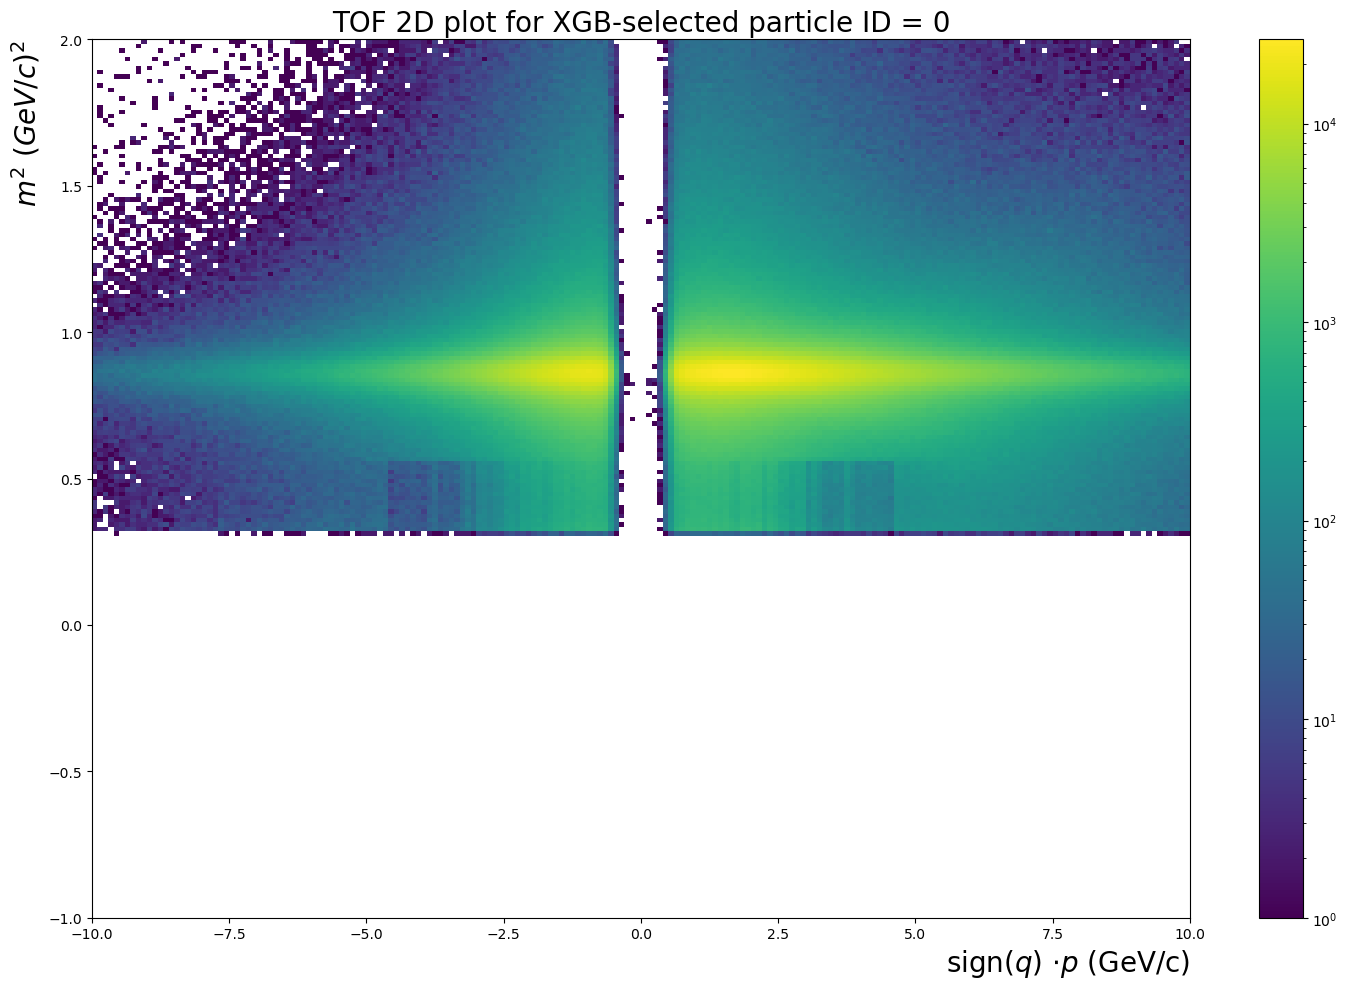

In [28]:
xgb_tof(0)

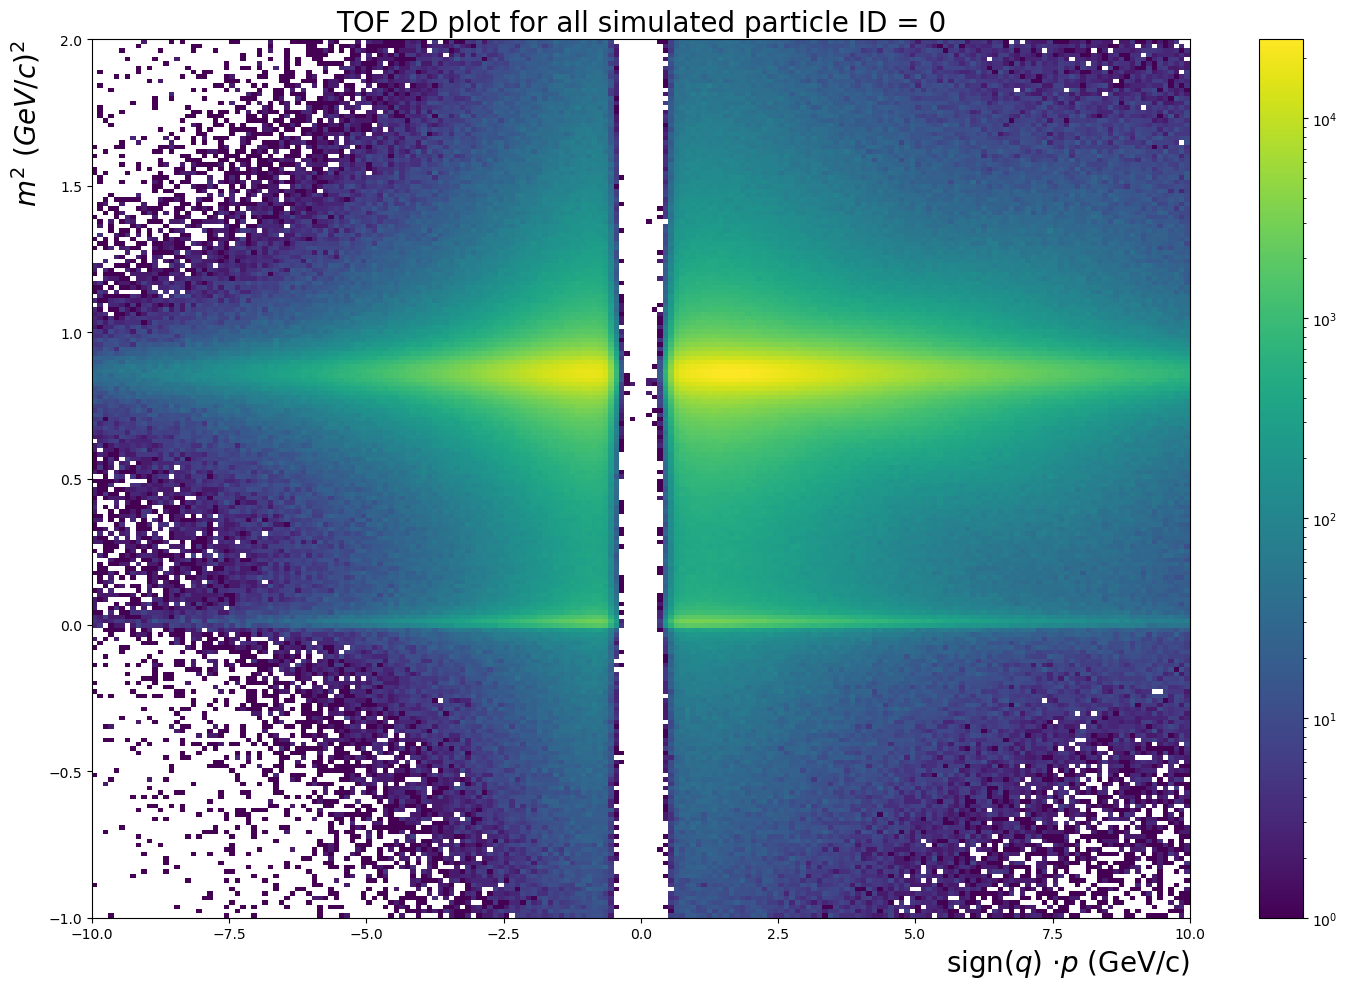

In [29]:
sim_tof(0)

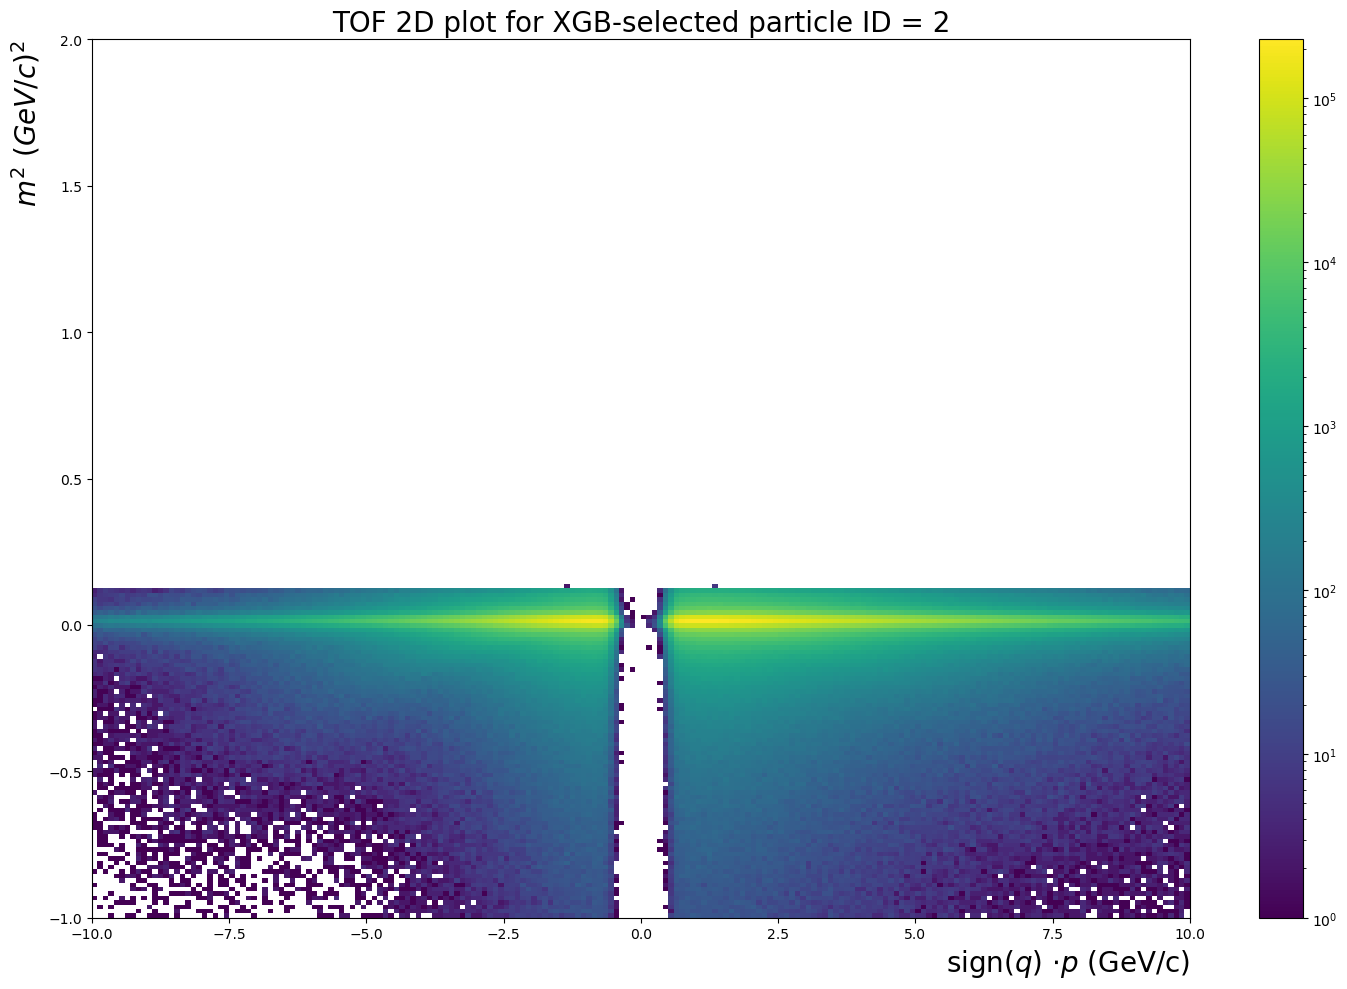

In [30]:
xgb_tof(2)

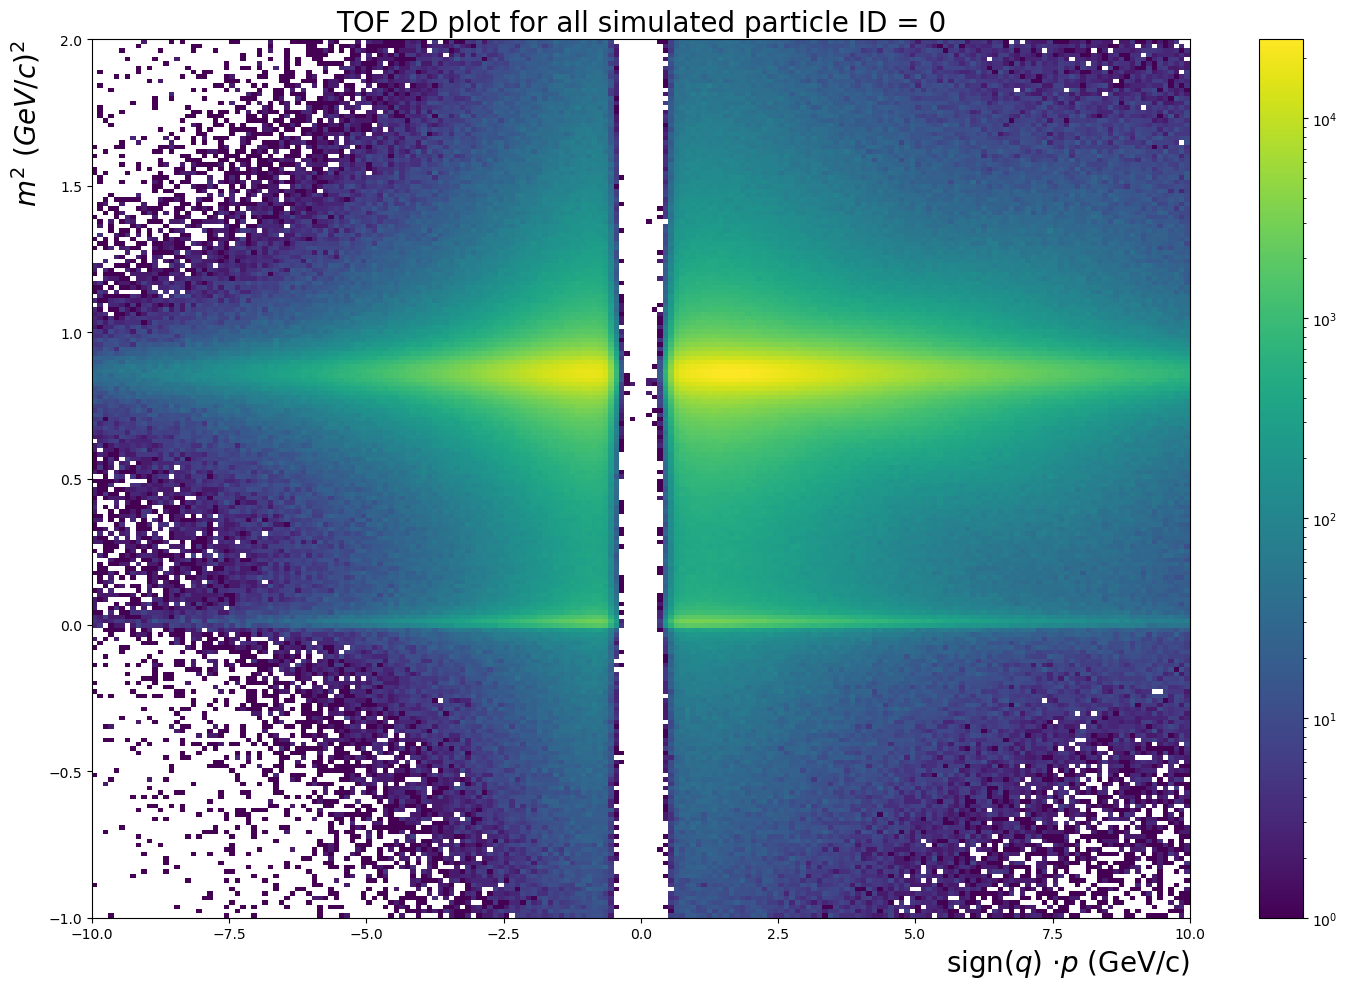

In [31]:
sim_tof(0)

What probability cuts to choose? there's no clear distribution? Is it beacause of hyperparameters?

In [32]:
#set probability cut
probaProton, probaKaon, probaPion,  = .95, .95, .95
whole_test = xgb_preds(whole_test, probaProton, probaKaon, probaPion)
particlesTest.index = whole_test.index
particlesTest['xgb_preds'] = whole_test['xgb_preds']

In [33]:
particlesTest.iloc[0:10,:]

,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q,xgb_preds
0,2.795109,796.765564,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,26.631847,2,-1.0,2
1,2.862100,797.093079,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,26.975466,1,1.0,1
2,2.025051,785.335205,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,27.855837,0,1.0,0
3,1.962085,745.262451,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,25.919329,0,1.0,0
4,2.162448,734.718689,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,24.501303,2,-1.0,2
5,3.121445,792.576599,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,26.742485,0,1.0,0
6,2.217318,759.005249,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,27.027834,0,1.0,0
7,2.333610,749.677795,0.139570,0.015155,3.696914,0.710121,2.618707,-0.615236,0.354622,3.628071,2.315019,25.072449,2,1.0,2
8,2.156020,733.076660,0.139570,0.015053,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,2.150286,24.501919,2,1.0,2
9,2.211525,769.359009,0.139570,0.018099,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,25.997503,2,1.0,2


Confusion matrix, without normalization
[[12378331   206298   642615   636707]
 [   16787  1007917   161492   187718]
 [ 1068613   356283 25204014   421175]
 [    7084      947    11190     1171]]


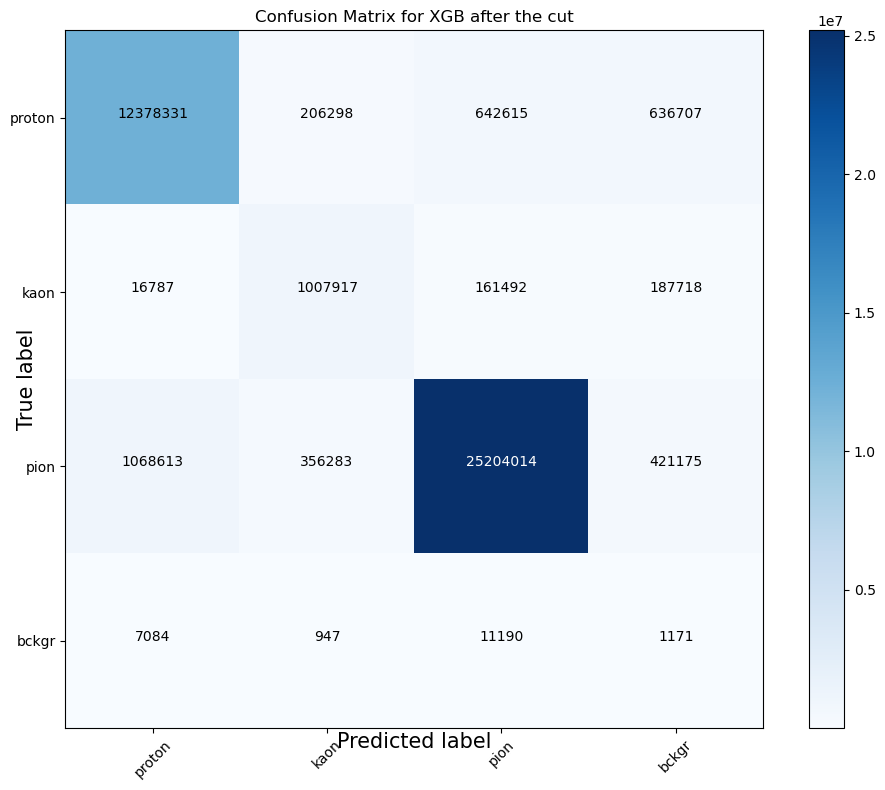

In [34]:
classes = ['proton', 'kaon', 'pion', 'bckgr']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
title = 'Confusion Matrix for XGB after the cut'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=False)
fig.savefig(directory+'img/' + title + '.pdf')

plt.show()

Normalized confusion matrix
[[0.89 0.01 0.05 0.05]
 [0.01 0.73 0.12 0.14]
 [0.04 0.01 0.93 0.02]
 [0.35 0.05 0.55 0.06]]


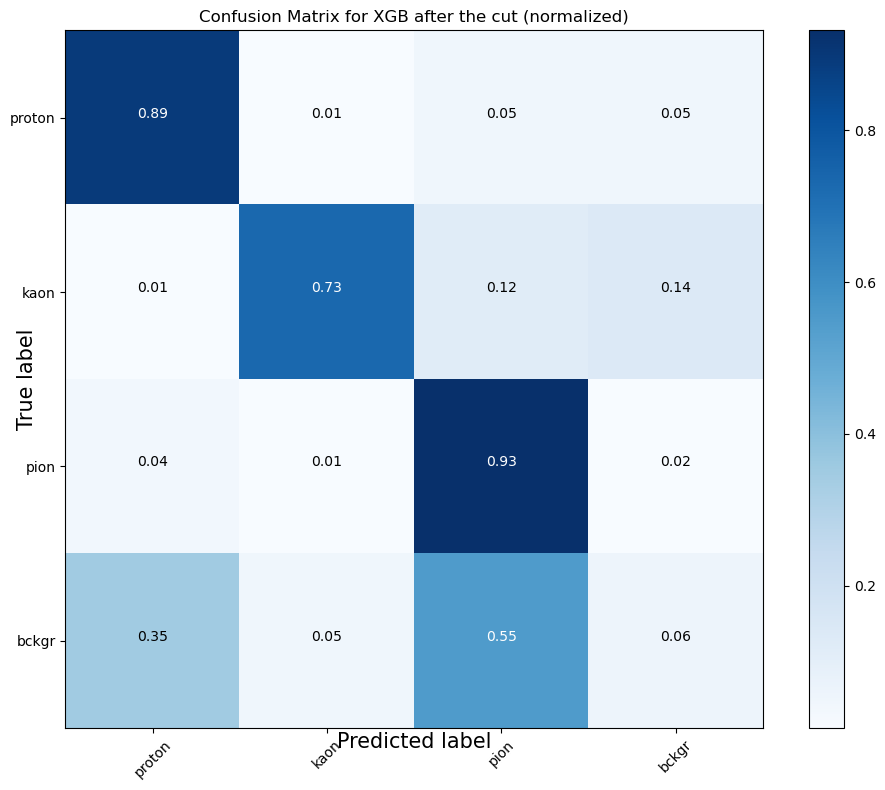

In [115]:
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)

title = 'Confusion Matrix for XGB after the cut (normalized)'
plot_confusion_matrix(cnf_matrix, classes=classes, title=title, normalize=True)
fig.savefig(directory+'img/' + title + '.pdf')

plt.show()

In [119]:
def confusion_stats(df, cm, pid):
    all_signals = len(df.loc[df['pid'] == pid])
    true_signal = cm[pid][pid]
    false_signal = 0
    for i in range(len(cnf_matrix)):
        if i != pid:
            false_signal += cm[pid][i] + cm[i][pid]
    reconstructed_signals = true_signal + false_signal
    false_to_true_signals = false_signal / true_signal
    efficiency = reconstructed_signals / all_signals * 100 #efficency in % for all
    efficiency_true = true_signal / all_signals * 100 #efficency in % for all
    print("For particle ID = " + str(pid) + ": ")
    print("Efficiency: " + str(round(efficiency, 2)) + "%")
    print("Efficiency of true signal candidates reconstruction: " + str(round(efficiency_true, 2)) + "%")
    print("False tu true positives ratio: " + str(round(false_to_true_signals, 2)))
    
confusion_stats(whole_test, cnf_matrix, 0)
confusion_stats(whole_test, cnf_matrix, 1)
confusion_stats(whole_test, cnf_matrix, 2)

For particle ID = 0: 
Efficiency: 107.88%
Efficiency of true signal candidates reconstruction: 89.28%
False tu true positives ratio: 0.21
For particle ID = 1: 
Efficiency: 141.02%
Efficiency of true signal candidates reconstruction: 73.36%
False tu true positives ratio: 0.92
For particle ID = 2: 
Efficiency: 103.01%
Efficiency of true signal candidates reconstruction: 93.18%
False tu true positives ratio: 0.11


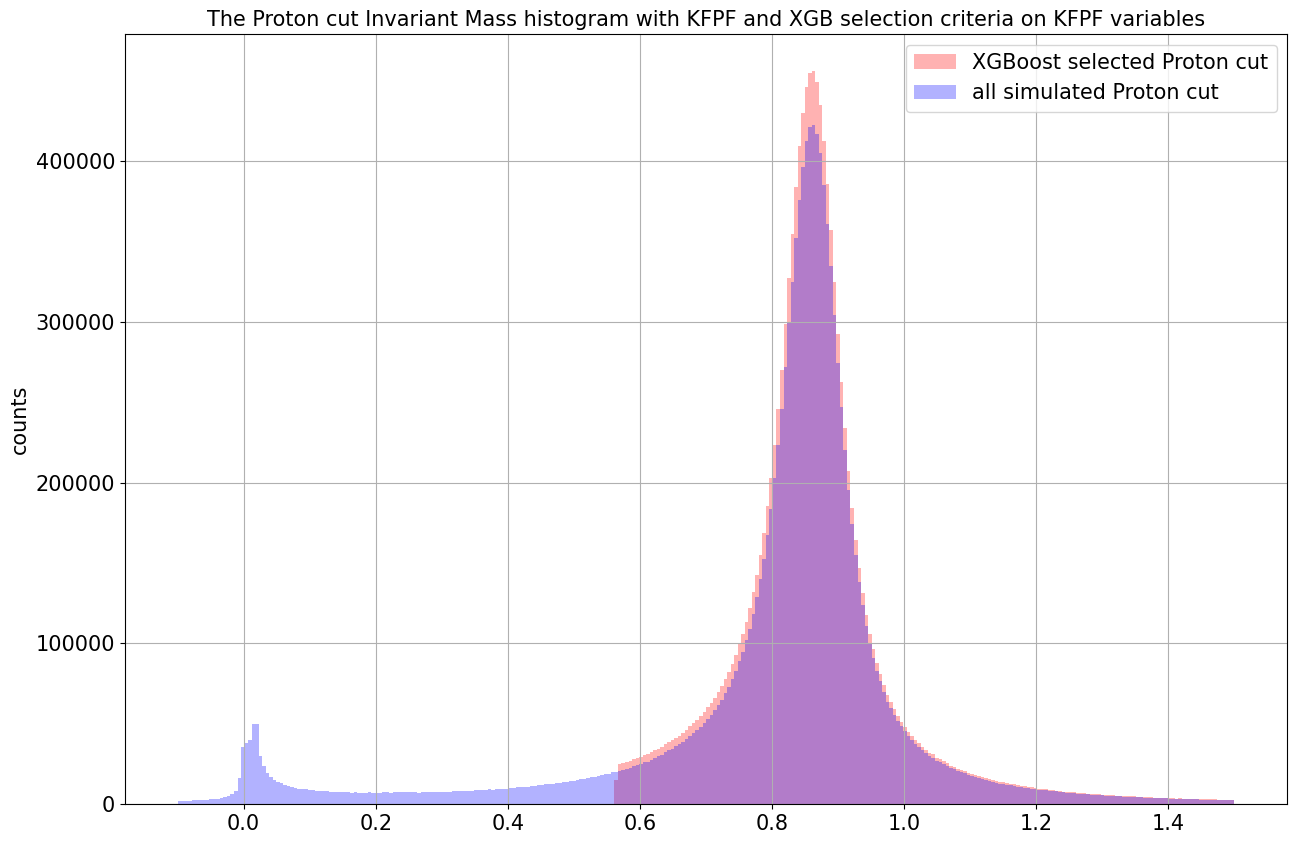

In [36]:
plot_mass2(0, 'Proton cut', (-.1, 1.5))

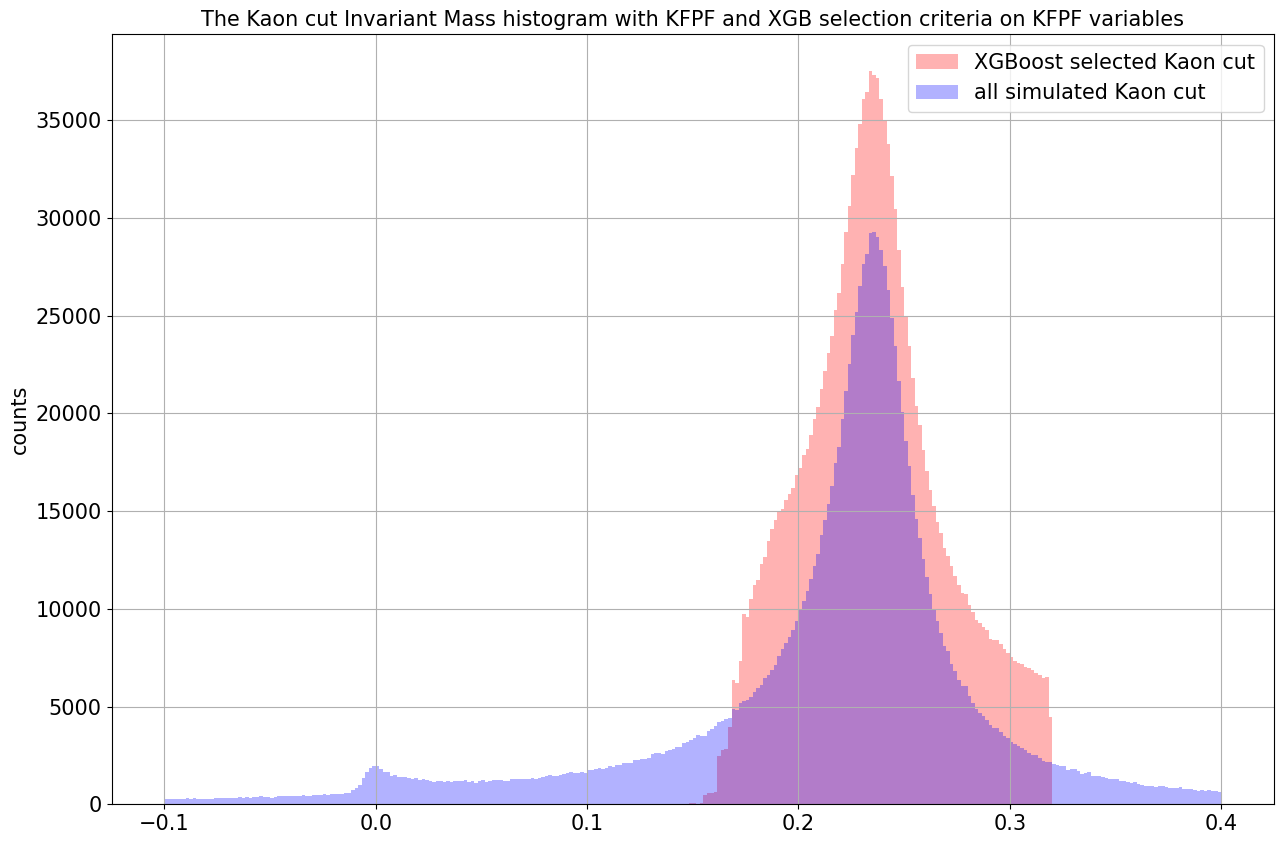

In [37]:
plot_mass2(1, 'Kaon cut', (-.1, .4))

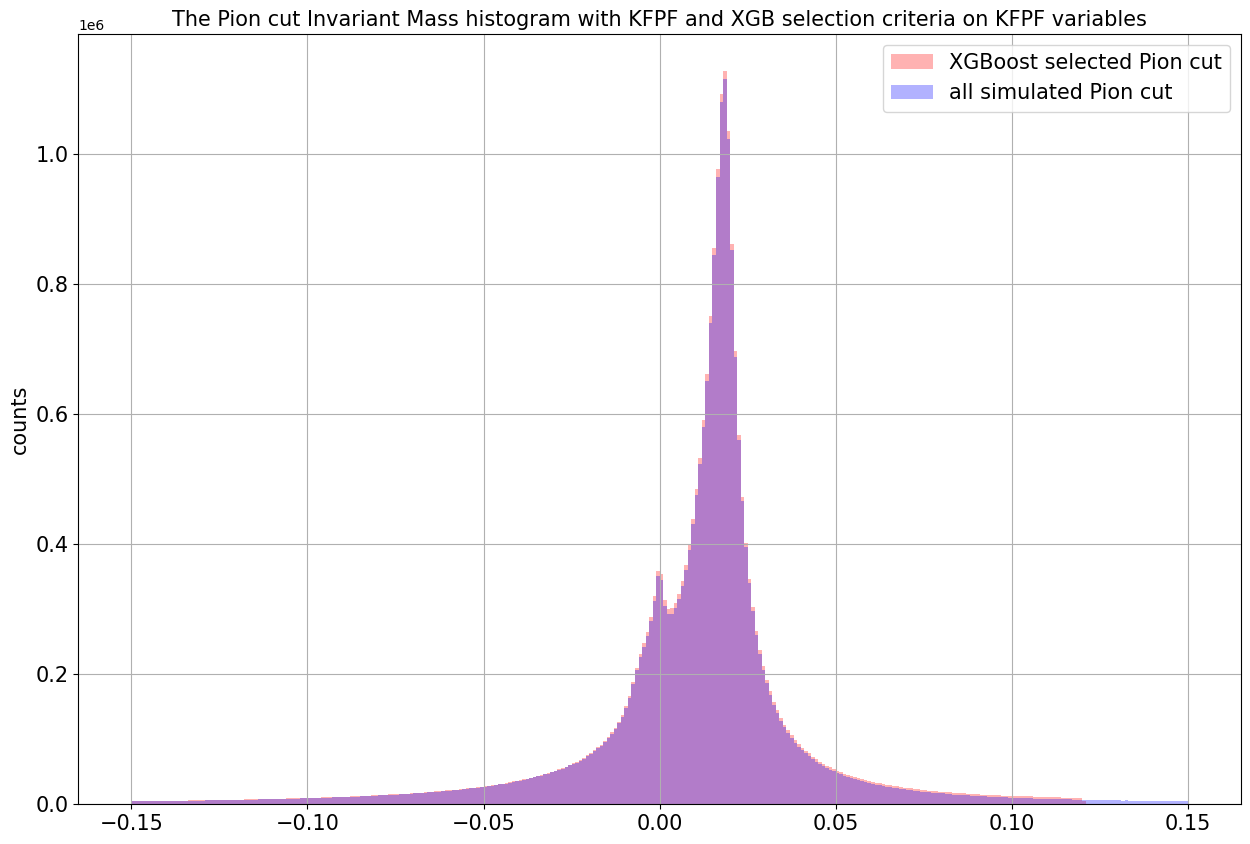

In [38]:
plot_mass2(2, 'Pion cut', (-.15, .15))

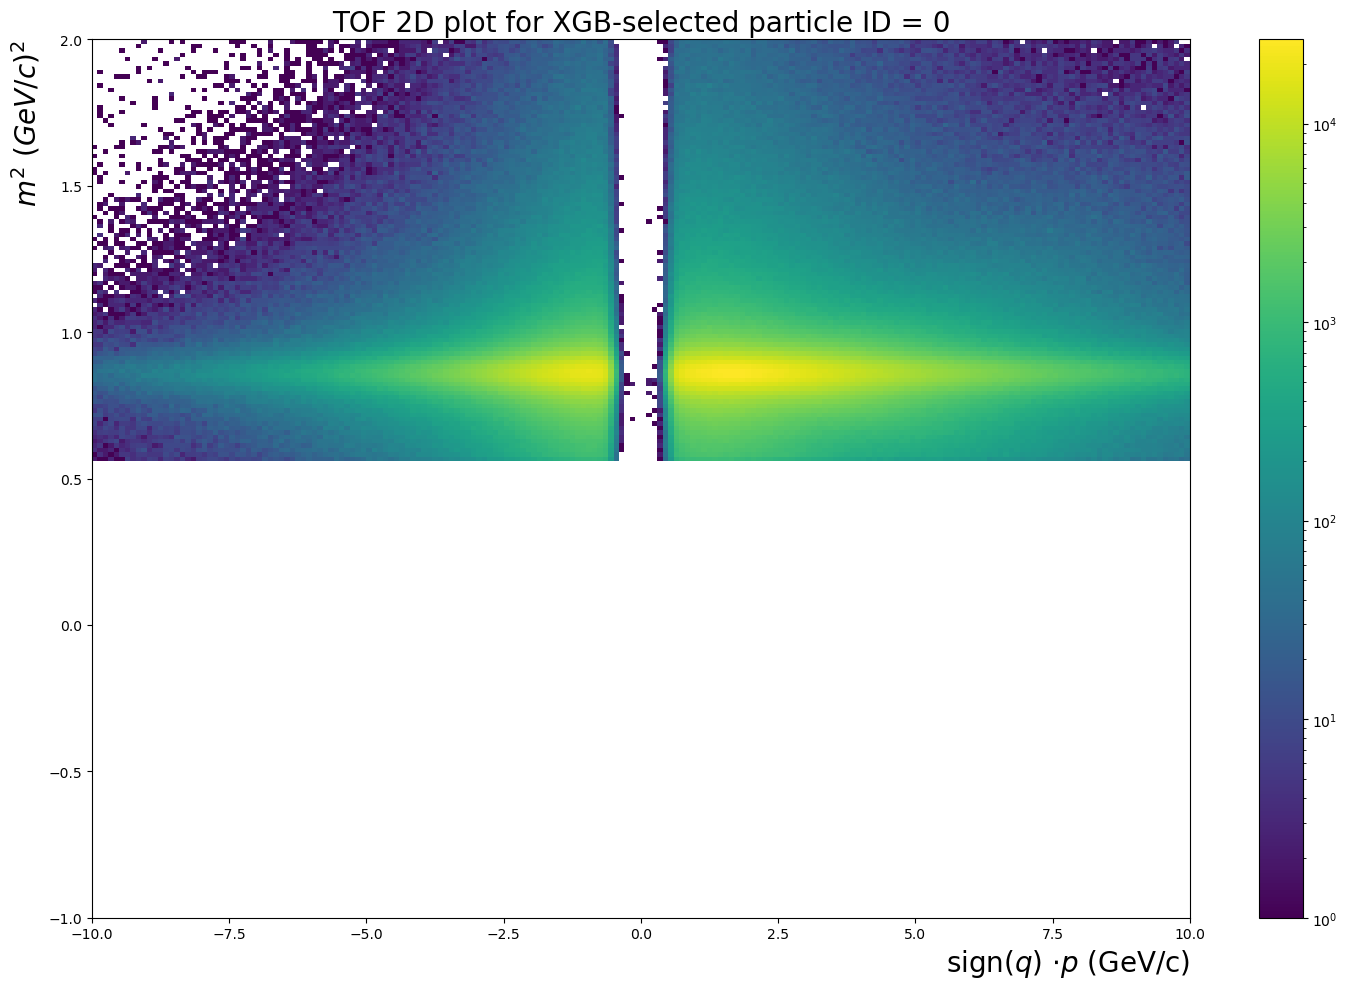

In [39]:
xgb_tof(0)

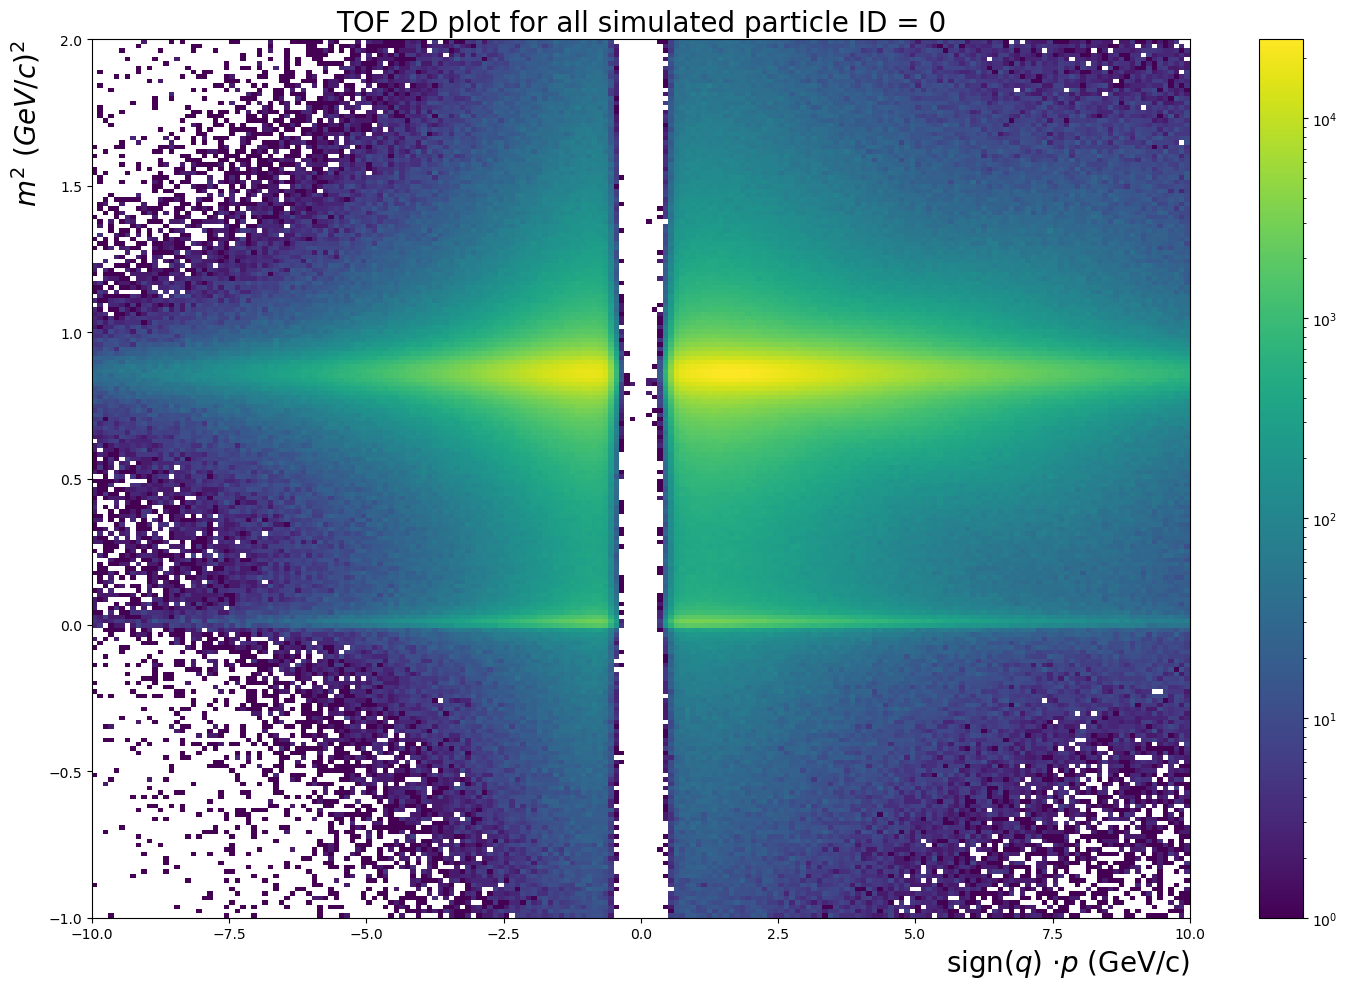

In [40]:
sim_tof(0)

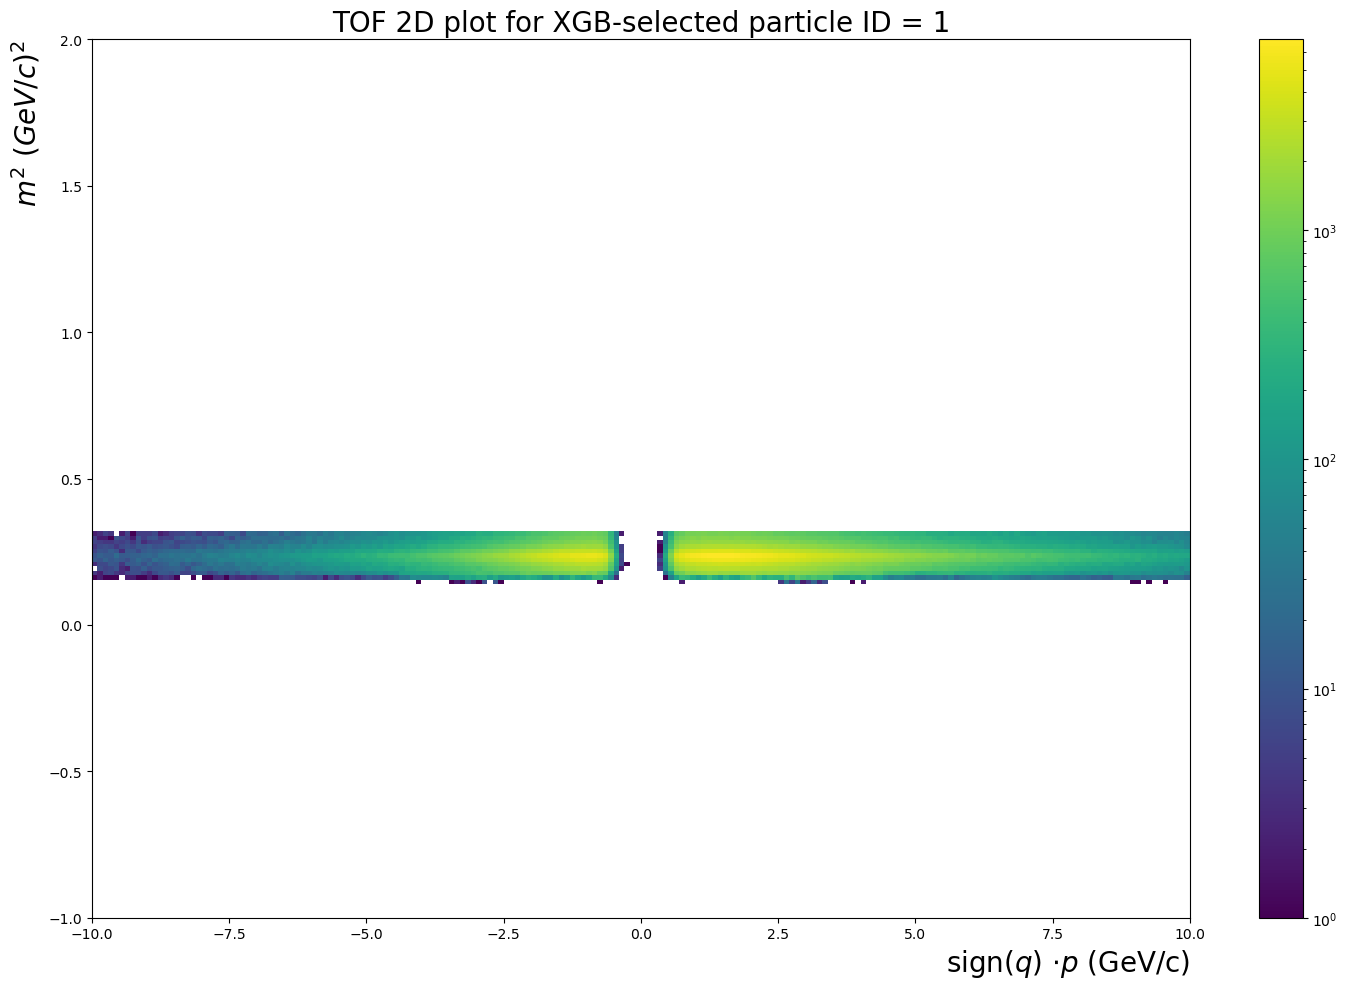

In [41]:
xgb_tof(1)

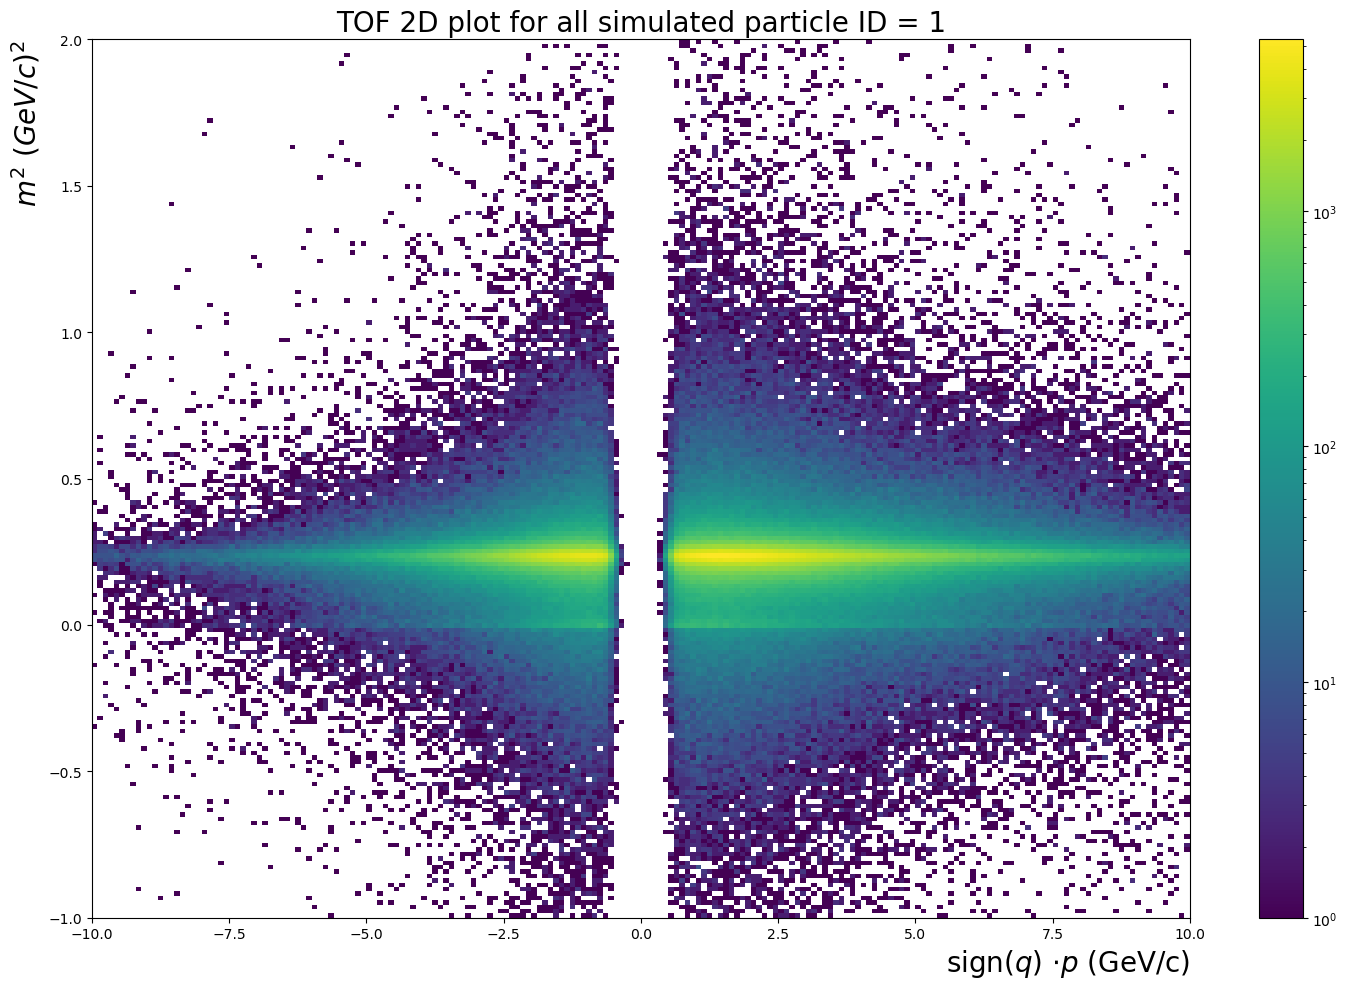

In [42]:
sim_tof(1)

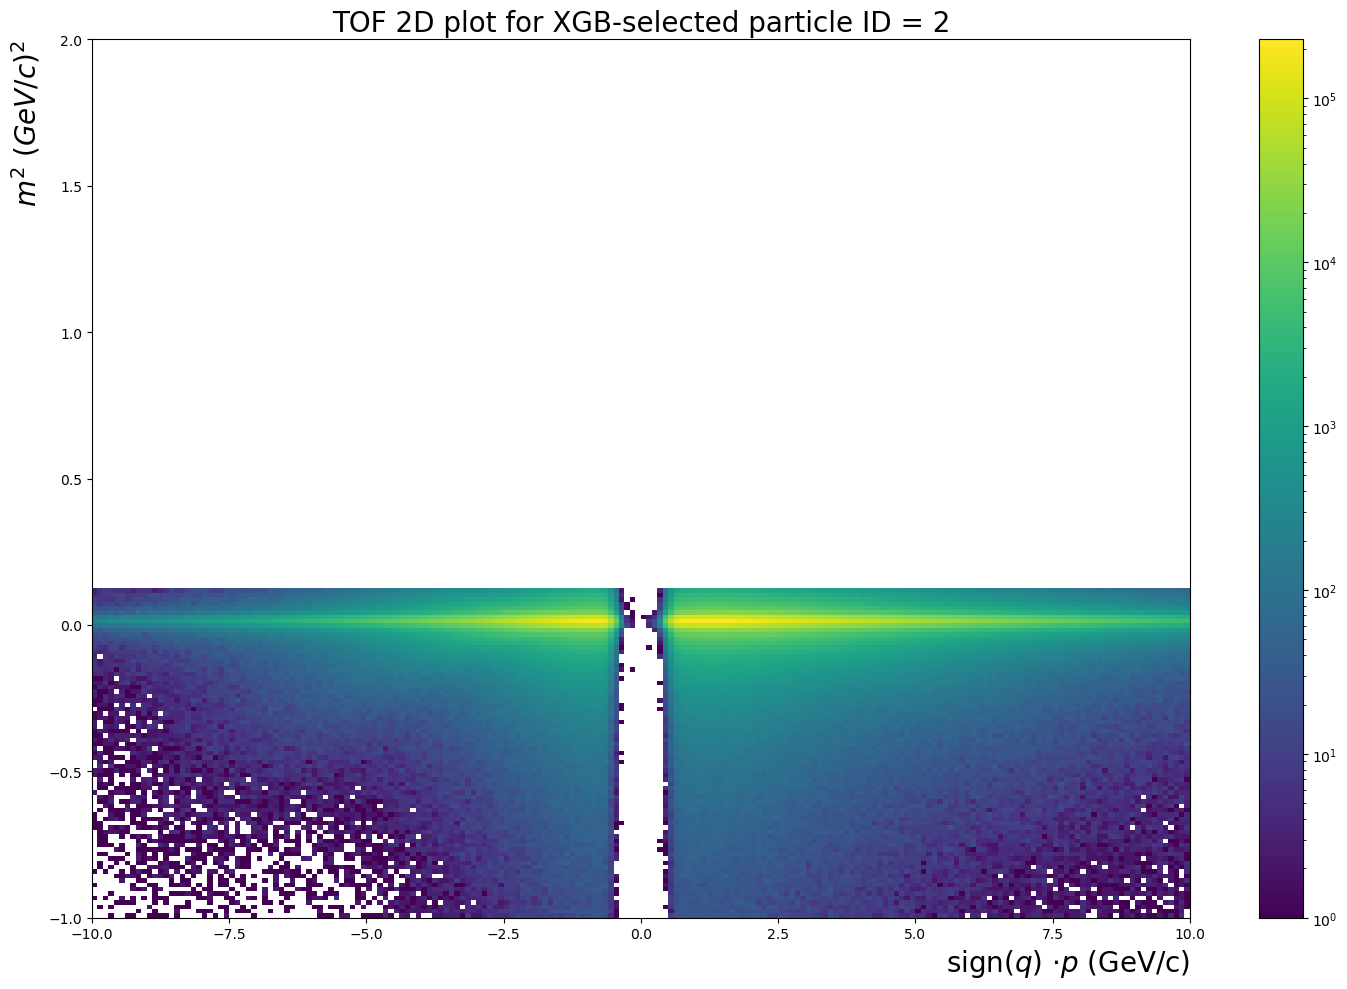

In [43]:
xgb_tof(2)

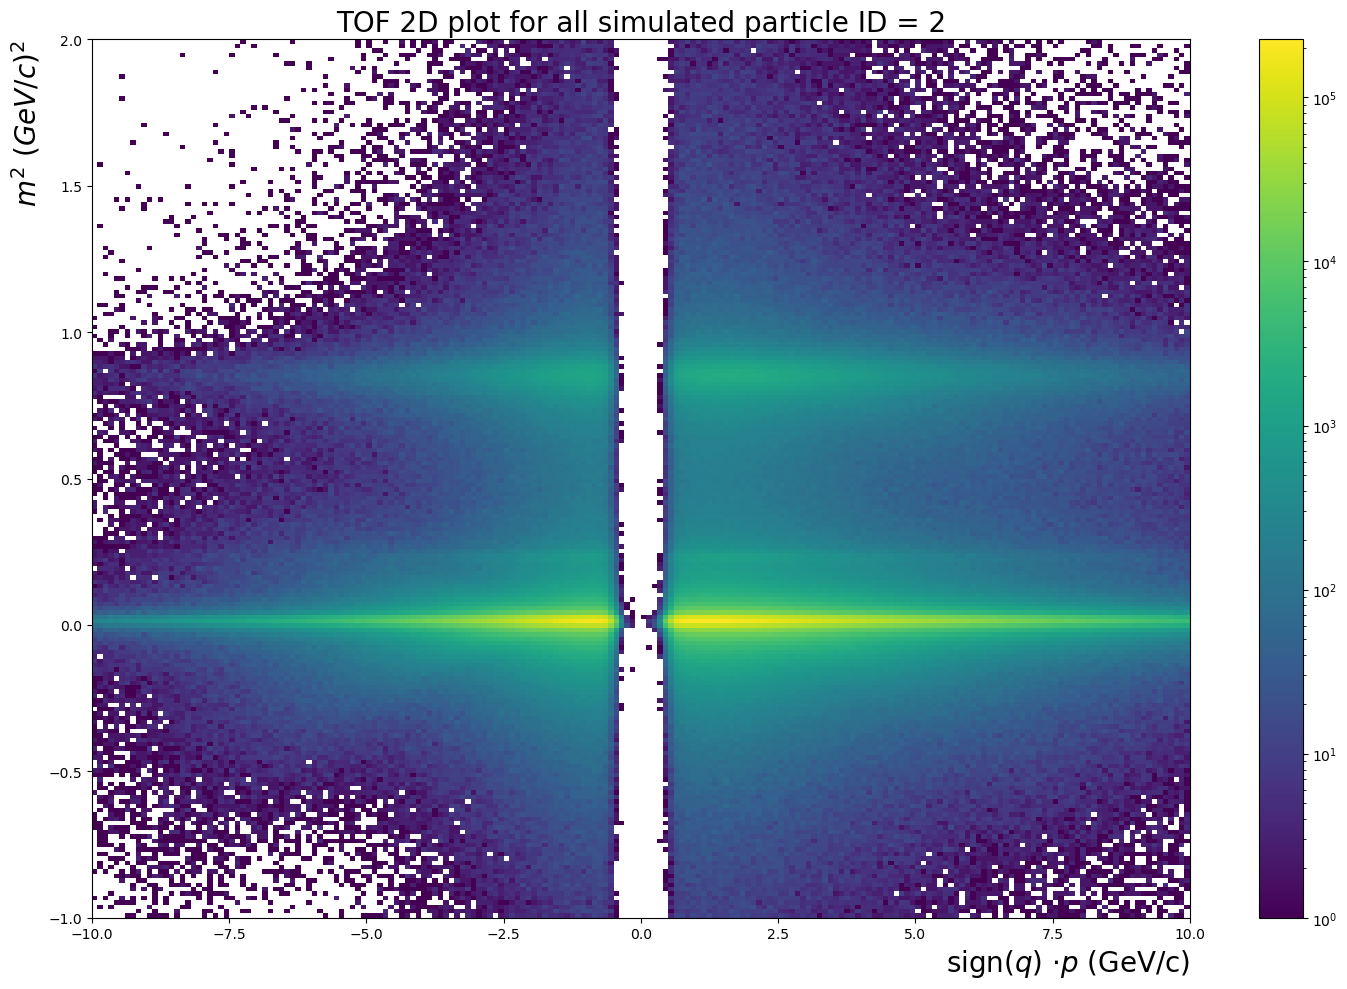

In [44]:
sim_tof(2)

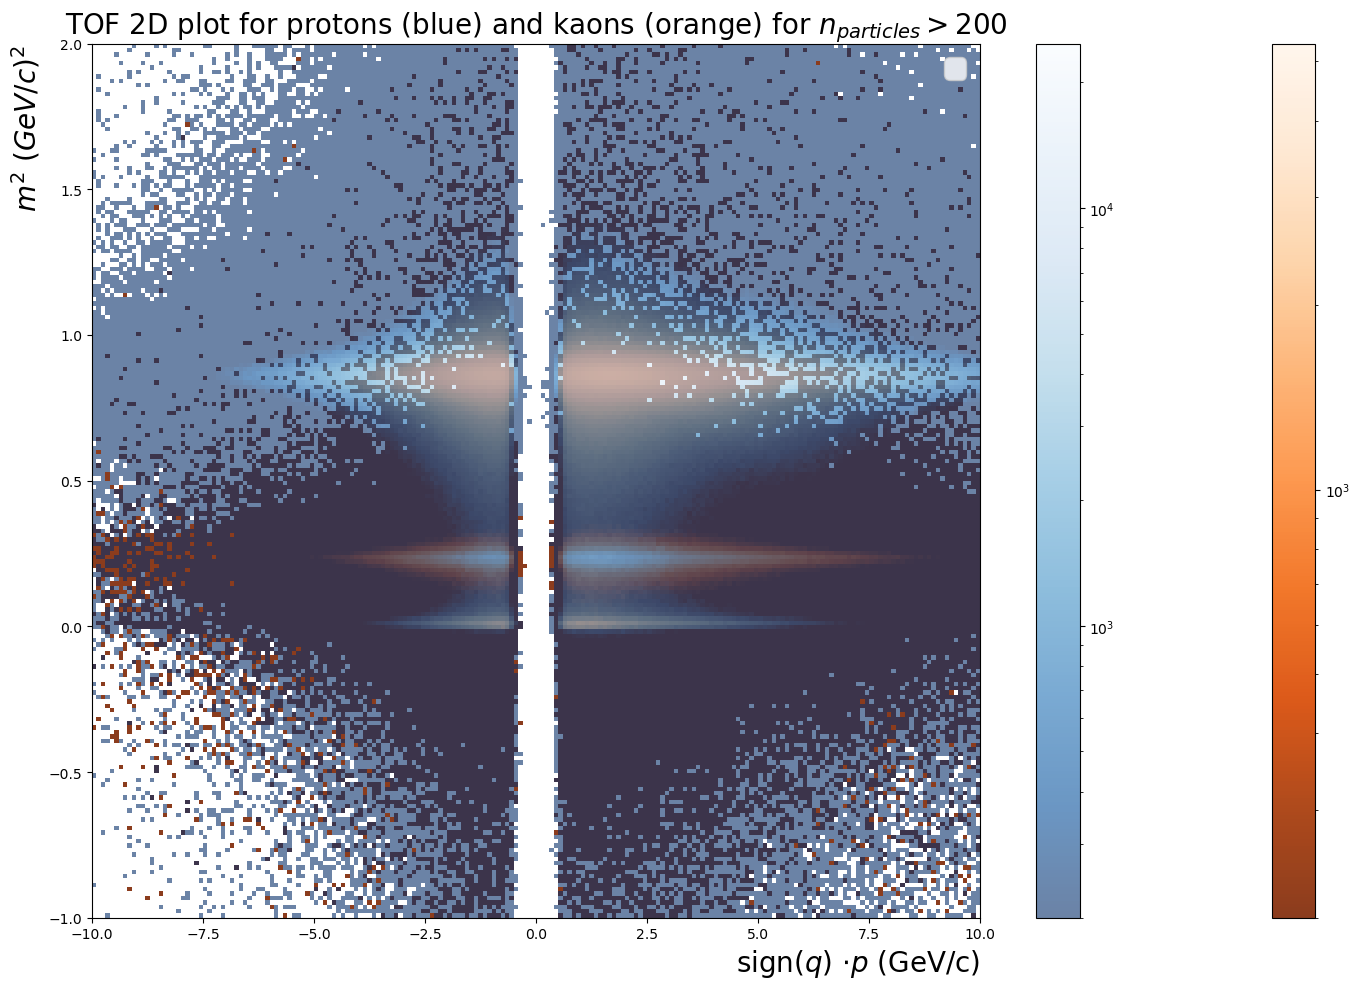

In [105]:
fig, axs = plt.subplots(figsize=(15, 10))

def subplot(pid, name, color, alpha):
    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)

subplot(1, 'kaons', 'Oranges_r', .9)
subplot(0, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for protons (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()

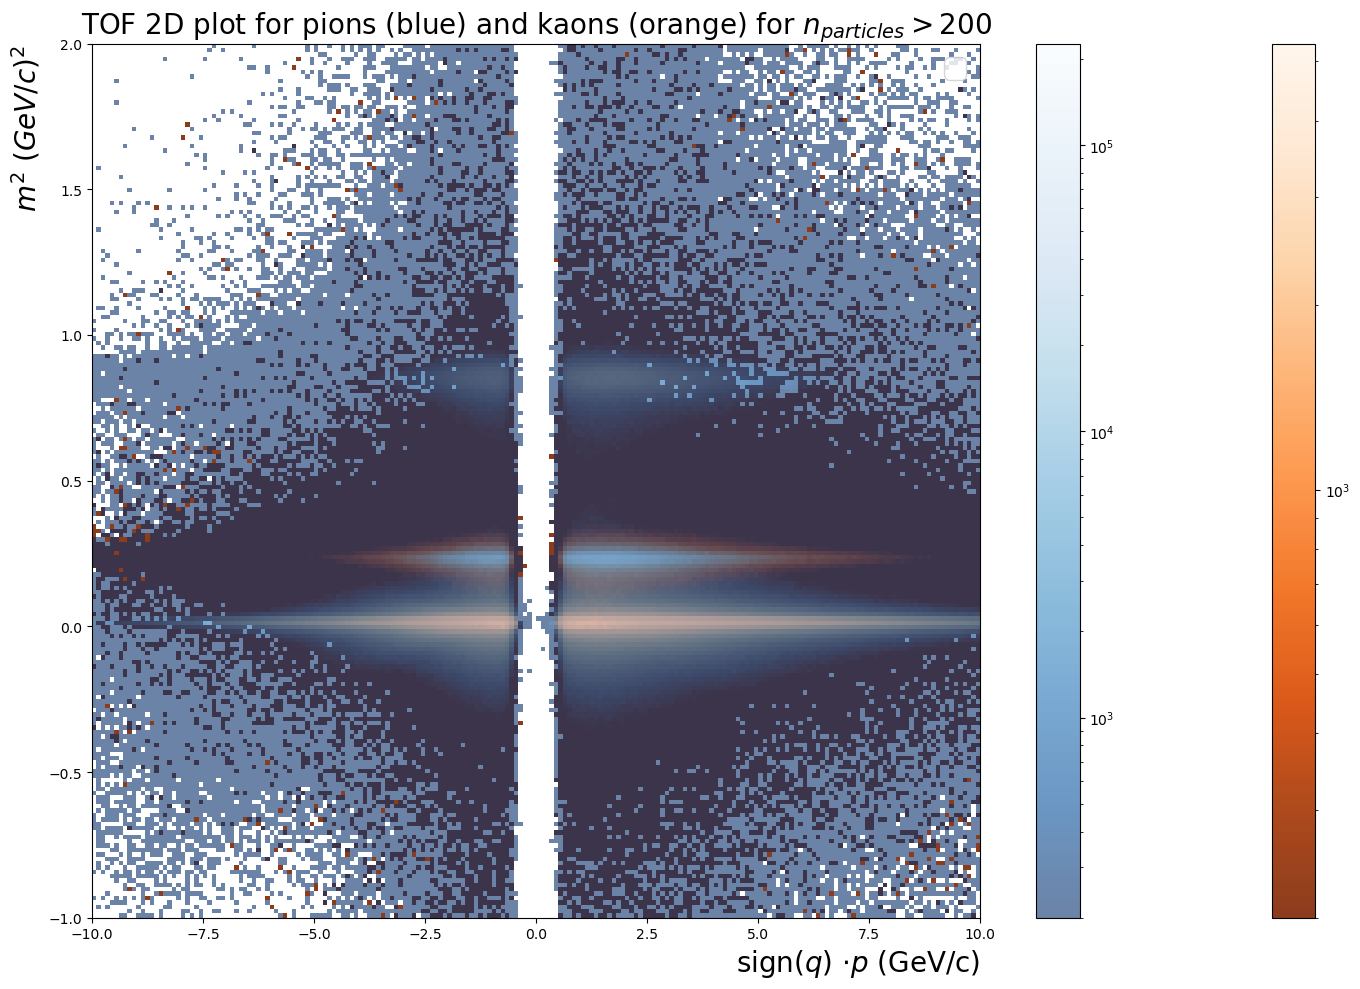

In [106]:
fig, axs = plt.subplots(figsize=(15, 10))

def subplot(pid, name, color, alpha):
    qp = particlesTest[particlesTest['pid']==pid]['q']*particlesTest[particlesTest['pid']==pid]['p']
    mass2 = particlesTest[particlesTest['pid']==pid]['mass2']
    counts, xedges, yedges, im = axs.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=200), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = alpha)
    plt.colorbar(im, ax=axs)
    # plt.hist2d(qp, mass2, bins=200, norm=mpl.colors.LogNorm(vmin=100), cmap=plt.cm.get_cmap(color), range=ranges, label= name, alpha = 0.9)

subplot(1, 'kaons', 'Oranges_r', .9)
subplot(2, 'protons', 'Blues_r', .6)



plt.xlabel(xName, fontsize=20, loc='right')
plt.ylabel(yName, fontsize=20, loc='top')
title=r'TOF 2D plot for pions (blue) and kaons (orange) for $n_{particles} > 200$'
plt.title(title, fontsize=20)
axs.legend('Classes of particles', fontsize = 20, loc='upper right')
#axs.tick_params(labelsize=18)
fig.tight_layout()
plt.show()